<a href="https://colab.research.google.com/github/kugogt/Housing-Price-Prediction/blob/main/ML_python.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# King County House - Price Prediction

*Ciao*! This is my machine learning project, born out of a university course (you can guess a ML course) where we didn’t use Python. So, I decided to rewrite the whole thing in Python, partly for fun, partly to learn more along the way.

Compared to the original version, I’ve added a few extra parts that helped me study and understand things better. The goal here isn’t to get state-of-the-art results, but to build a solid and complete pipeline: something that’s clear, robust, reusable, and hopefully helpful for future projects too.

From the summary, you'll see that the project covers the full process: from exploring the data all the way to the final analysis and deployment. Here’s what’s inside:

1.   Data exploration
2.   Feature engineering transformation (with 3 different clustering proceses)
3.   Feature transformation
4.   A linear model baseline with feature selection using Elasticnet
5.   Non-linear models with RFECV feature selection (based on Random Forest)
6.   1-SE rule applied to simplify the feature selection
7.   Model training with Random Forest, Histogram Gradient Boosting, XGBoost, LightGBM and an MLP neural net
8.   A stacking model combining XGBoost and RF, with Ridge as the meta-model
9.   Evaluation of results, including visual analysis of residuals and confidence intervals
10.  SHAP analysis for XGBoost interpretation

Also, since I haven’t mentioned it elsewhere: in this project, I’ll be minimizing MAE (Mean Absolute Error) instead of MSE (Mean Squared Error).

Why MAE? This project is about predicting house prices, where prices can vary widely, with a small number of very expensive properties that act as outliers. MSE penalizes large errors much more heavily than small ones, so it tends to give disproportionate importance to those few high-priced houses. That can distort the model’s performance for the majority of homes in the dataset.

By minimizing MAE instead, we reduce the influence of those outliers and get a model that performs more consistently across the typical price range, which is ultimately more useful and realistic.

Hope you enjoy going through it, and if you have any ideas or suggestions to improve it, I’d love to hear them!


# Installations, Libraries & Dataset upload

In [ ]:
# --- Installation

!pip install category_encoders scikit-optimize mapie==0.9.0 haversine shap optuna optuna-integration[sklearn] mlflow pyngrok  -q

In [ ]:
# --- Libraries

# Standard library
import os
import random
import joblib

# Core scientific stack
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import seaborn as sns

# Geospatial & math utilities
from haversine import haversine, Unit
from pyproj import Proj, Transformer

# Statistical & explanatory analysis
import shap
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Scikit-learn: clustering & metrics
from sklearn.cluster import KMeans, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import (
    silhouette_score,
    calinski_harabasz_score,
    davies_bouldin_score,
    silhouette_samples,
    mean_squared_error,
    mean_absolute_error,
    r2_score,
    mean_absolute_percentage_error
)

# Scikit-learn: preprocessing & modeling
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor, StackingRegressor
from sklearn.linear_model import ElasticNetCV, Ridge, LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.feature_selection import RFECV, SelectFromModel

# Encoding & gradient boosting frameworks
import category_encoders as ce
from xgboost import XGBRegressor
import lightgbm as lgb

# Prediction intervals
from mapie.regression import MapieRegressor, MapieQuantileRegressor
from mapie.metrics import regression_coverage_score, regression_mean_width_score

# Hyperparameter optimization
from optuna.integration import OptunaSearchCV
import optuna.distributions as od
from optuna.samplers import RandomSampler

# Experiment tracking & tunneling
import mlflow
from mlflow.tracking import MlflowClient
from pyngrok import ngrok

In [ ]:
# --- MLflow setup

mlflow.set_experiment("King County House Prices")

print(f"MLflow Version: {mlflow.__version__}")
print(f"Tracking URI: {mlflow.get_tracking_uri()}")

MLflow Version: 3.2.0
Tracking URI: file:///content/mlruns


In [ ]:
# --- Paths of models savings

model_results_path = "/content/drive/My Drive/Colab Notebooks/all_model_results.joblib"

if os.path.exists(model_results_path):
    model_results = joblib.load(model_results_path)
    print(f"Loaded {len(model_results)} existing model results.")
else:
    print("No existing results file found. Starting with an empty dictionary.")
    model_results = {}

Loaded 12 existing model results.


In [ ]:
# --- Updload the dataset

df = pd.read_csv("/content/drive/My Drive/kc_house_data.csv")
df.head()

id             date     price  bedrooms  bathrooms  sqft_living  \
0  7129300520  20141013T000000  221900.0         3       1.00         1180   
1  6414100192  20141209T000000  538000.0         3       2.25         2570   
2  5631500400  20150225T000000  180000.0         2       1.00          770   
3  2487200875  20141209T000000  604000.0         4       3.00         1960   
4  1954400510  20150218T000000  510000.0         3       2.00         1680   

   sqft_lot  floors  waterfront  view  ...  grade  sqft_above  sqft_basement  \
0      5650     1.0           0     0  ...      7        1180              0   
1      7242     2.0           0     0  ...      7        2170            400   
2     10000     1.0           0     0  ...      6         770              0   
3      5000     1.0           0     0  ...      7        1050            910   
4      8080     1.0           0     0  ...      8        1680              0   

   yr_built  yr_renovated  zipcode      lat     long  sqft_living15  \
0      1955             0    98178  47.5112 -122.257           1340   
1      1951          1991    98125  47.7210 -122.319           1690   
2      1933             0    98028  47.7379 -122.233           2720   
3      1965             0    98136  47.5208 -122.393           1360   
4      1987             0    98074  47.6168 -122.045           1800   

   sqft_lot15  
0        5650  
1        7639  
2        8062  
3        5000  
4        7503  

[5 rows x 21 columns]

# Data exploration

In [ ]:
# --- Data type and presence of missing values

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21613 non-null  int64  
 1   date           21613 non-null  object 
 2   price          21613 non-null  float64
 3   bedrooms       21613 non-null  int64  
 4   bathrooms      21613 non-null  float64
 5   sqft_living    21613 non-null  int64  
 6   sqft_lot       21613 non-null  int64  
 7   floors         21613 non-null  float64
 8   waterfront     21613 non-null  int64  
 9   view           21613 non-null  int64  
 10  condition      21613 non-null  int64  
 11  grade          21613 non-null  int64  
 12  sqft_above     21613 non-null  int64  
 13  sqft_basement  21613 non-null  int64  
 14  yr_built       21613 non-null  int64  
 15  yr_renovated   21613 non-null  int64  
 16  zipcode        21613 non-null  int64  
 17  lat            21613 non-null  float64
 18  long  

There are NO missing values!

In [ ]:
# --- "Zipcode" var from int64 to category

# This is done to use it as a "Target Encoding" in the future steps
df["zipcode"]= df.zipcode.astype("category")

df["zipcode"].dtype

CategoricalDtype(categories=[98001, 98002, 98003, 98004, 98005, 98006, 98007, 98008,
                  98010, 98011, 98014, 98019, 98022, 98023, 98024, 98027,
                  98028, 98029, 98030, 98031, 98032, 98033, 98034, 98038,
                  98039, 98040, 98042, 98045, 98052, 98053, 98055, 98056,
                  98058, 98059, 98065, 98070, 98072, 98074, 98075, 98077,
                  98092, 98102, 98103, 98105, 98106, 98107, 98108, 98109,
                  98112, 98115, 98116, 98117, 98118, 98119, 98122, 98125,
                  98126, 98133, 98136, 98144, 98146, 98148, 98155, 98166,
                  98168, 98177, 98178, 98188, 98198, 98199],
, ordered=False, categories_dtype=int64)

In [ ]:
# --- Data variable

df["date"] = pd.to_datetime(df["date"])                                         # Data type
df["sale_year"] = df["date"].dt.year                                            # Year of sale
df["sale_month"] = df["date"].dt.month                                          # Month of sale
df["days_since_start"] = (df["date"] - df["date"].min()).dt.days                # How many days of the sales passed since star of recording?


In [ ]:
# --- Summary stats

df.describe().T

count                           mean                  min  \
id                21613.0              4580301520.864988            1000102.0   
date                21613  2014-10-29 04:38:01.959931648  2014-05-02 00:00:00   
price             21613.0                  540088.141767              75000.0   
bedrooms          21613.0                       3.370842                  0.0   
bathrooms         21613.0                       2.114757                  0.0   
sqft_living       21613.0                    2079.899736                290.0   
sqft_lot          21613.0                   15106.967566                520.0   
floors            21613.0                       1.494309                  1.0   
waterfront        21613.0                       0.007542                  0.0   
view              21613.0                       0.234303                  0.0   
condition         21613.0                        3.40943                  1.0   
grade             21613.0                       7.656873                  1.0   
sqft_above        21613.0                    1788.390691                290.0   
sqft_basement     21613.0                     291.509045                  0.0   
yr_built          21613.0                    1971.005136               1900.0   
yr_renovated      21613.0                      84.402258                  0.0   
lat               21613.0                      47.560053              47.1559   
long              21613.0                    -122.213896             -122.519   
sqft_living15     21613.0                    1986.552492                399.0   
sqft_lot15        21613.0                   12768.455652                651.0   
sale_year         21613.0                    2014.322954               2014.0   
sale_month        21613.0                       6.574423                  1.0   
days_since_start  21613.0                     180.193078                  0.0   

                                  25%                  50%  \
id                       2123049194.0         3904930410.0   
date              2014-07-22 00:00:00  2014-10-16 00:00:00   
price                        321950.0             450000.0   
bedrooms                          3.0                  3.0   
bathrooms                        1.75                 2.25   
sqft_living                    1427.0               1910.0   
sqft_lot                       5040.0               7618.0   
floors                            1.0                  1.5   
waterfront                        0.0                  0.0   
view                              0.0                  0.0   
condition                         3.0                  3.0   
grade                             7.0                  7.0   
sqft_above                     1190.0               1560.0   
sqft_basement                     0.0                  0.0   
yr_built                       1951.0               1975.0   
yr_renovated                      0.0                  0.0   
lat                            47.471              47.5718   
long                         -122.328              -122.23   
sqft_living15                  1490.0               1840.0   
sqft_lot15                     5100.0               7620.0   
sale_year                      2014.0               2014.0   
sale_month                        4.0                  6.0   
days_since_start                 81.0                167.0   

                                  75%                  max                std  
id                       7308900445.0         9900000190.0  2876565571.312049  
date              2015-02-17 00:00:00  2015-05-27 00:00:00                NaN  
price                        645000.0            7700000.0      367127.196483  
bedrooms                          4.0                 33.0           0.930062  
bathrooms                         2.5                  8.0           0.770163  
sqft_living                    2550.0              13540.0         918.440897  
sqft_lot                  

In [ ]:
# --- Data input error correction

# From the previous table we can notice the presence of a particular max value for the number of bedrooms: 33. Lest's investigate it
df_33_bedrooms = df[df["bedrooms"] == 33]
df_33_bedrooms

id       date     price  bedrooms  bathrooms  sqft_living  \
15870  2402100895 2014-06-25  640000.0        33       1.75         1620   

       sqft_lot  floors  waterfront  view  ...  yr_built  yr_renovated  \
15870      6000     1.0           0     0  ...      1947             0   

       zipcode      lat     long  sqft_living15 sqft_lot15  sale_year  \
15870    98103  47.6878 -122.331           1330       4700       2014   

       sale_month  days_since_start  
15870           6                54  

[1 rows x 24 columns]

In [ ]:
# It must be an inmput error! An house with the price of 640000.0$, 1620 ft^2 (150,5 m^2) CAN'T HAVE 33 bedrooms, lets correct it instead of delete the observation
df["bedrooms"] = df["bedrooms"].replace(33, 3)
df[df["id"] == 2402100895]

id       date     price  bedrooms  bathrooms  sqft_living  \
15870  2402100895 2014-06-25  640000.0         3       1.75         1620   

       sqft_lot  floors  waterfront  view  ...  yr_built  yr_renovated  \
15870      6000     1.0           0     0  ...      1947             0   

       zipcode      lat     long  sqft_living15 sqft_lot15  sale_year  \
15870    98103  47.6878 -122.331           1330       4700       2014   

       sale_month  days_since_start  
15870           6                54  

[1 rows x 24 columns]

In [ ]:
# --- Other limit case

# Let's check if are any house with 0 bedrooms and bathrooms with a price > 700k$
df[(df["price"] > 700000) & (df["bedrooms"] == 0) & (df["bathrooms"] == 0)]

id       date      price  bedrooms  bathrooms  sqft_living  \
875   6306400140 2014-06-12  1095000.0         0        0.0         3064   
6994  2954400190 2014-06-24  1295650.0         0        0.0         4810   

      sqft_lot  floors  waterfront  view  ...  yr_built  yr_renovated  \
875       4764     3.5           0     2  ...      1990             0   
6994     28008     2.0           0     0  ...      1990             0   

      zipcode      lat     long  sqft_living15 sqft_lot15  sale_year  \
875     98102  47.6362 -122.322           2360       4000       2014   
6994    98053  47.6642 -122.069           4740      35061       2014   

      sale_month  days_since_start  
875            6                41  
6994           6                53  

[2 rows x 24 columns]

In [ ]:
# Yes! Let's remove these values instead of tring to correct them
df = df[~df["id"].isin(["6306400140", "2954400190"])]

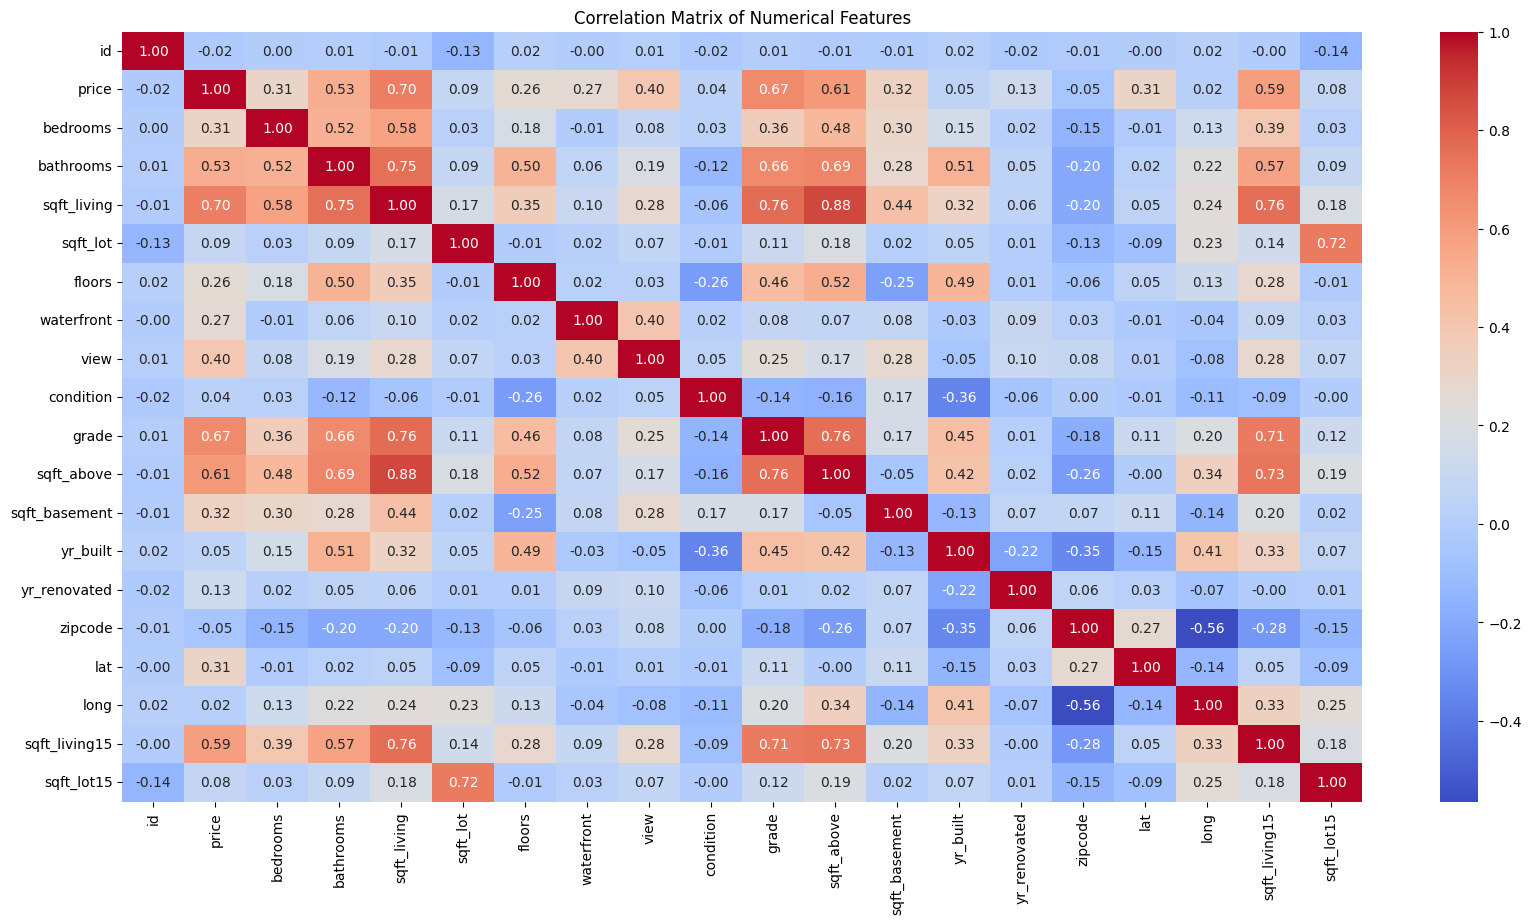

In [ ]:
# --- Data Linear Correlations plot

correlation_df = df.copy()
plt.figure(figsize=(20, 10))
corr_cols = correlation_df.select_dtypes(include=np.number).columns
correlation_matrix = correlation_df[corr_cols].corr()
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix of Numerical Features")
plt.show()

**Key predictors of house price:**

*   sqft_living (0.70): This is the strongest predictor. The single biggest factor in a home"s price is its size.

*   grade (0.67): This is also a very strong predictor. It represents the quality of construction and design. This tells us that high-quality construction is almost as important as size in determining price.

* sqft_above (0.61) & sqft_living15 (0.59): These are also very strong. sqft_living15 is particularly interesting since it shows that the size of neighboring houses is a powerful indicator of a home"s price.

* bathrooms (0.53): More bathrooms strongly correlate with a higher price.

* lat (Latitude) (0.31): In King County, higher latitude generally corresponds to more desirable and expensive neighborhoods north of Seattle. This may be due to their proximity to the center of Seattle.


**Strong Multicollinearity:**

*   sqft_living and sqft_above (0.88): They are highly redundant since sqft_living is the sum of sqft_above and sqft_basement. .

*   sqft_living and grade (0.76): Bigger houses seems to tend to be built to a higher grade/quality.

* sale_year and days_since_start (0.85): "Mechanical relationship" from feature engineering. They are essentially the same information.

* sale_year and sale_month (-0.78): This strong negative correlation is an artifact of the dataset"s time range. The data likely spans from 2014-10-29 to 2015-05-27. Therefore, sales in 2014 have high month numbers (5,12), while sales in 2015 have low month numbers (1,5), creating the negative trend.


**Other insight:**



*   condition vs. price (0.04): This ver low relationship implies that the cosmetic condition of a house is FAR less important to its price thant its "grade".
*   view and waterfront: These features have a decent correlation with price (0.40 and 0.27), but their correlation with each other is also remarkable (0.40). An house with waterfront is almost certainly to have a great view".



# Feature Engineering

In [ ]:
df.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15', 'sale_year', 'sale_month',
       'days_since_start'],
      dtype='object')

In [ ]:
# --- New feature create through interactions

df["ratio_living_size15"] = df["sqft_living"] / df["sqft_living15"]
df["ratio_lot_size15"] = df["sqft_lot"]/df["sqft_lot15"]
df["living_lot_ratio"] = df["sqft_living"] / df["sqft_lot"]
df["volume"] = df["floors"]*df["sqft_living"]


print(df["ratio_living_size15"].head())
print(df["ratio_lot_size15"].head())
print(df["living_lot_ratio"].head())
print(df["volume"].head())

0    0.880597
1    1.520710
2    0.283088
3    1.441176
4    0.933333
Name: ratio_living_size15, dtype: float64
0    1.000000
1    0.948030
2    1.240387
3    1.000000
4    1.076903
Name: ratio_lot_size15, dtype: float64
0    0.208850
1    0.354874
2    0.077000
3    0.392000
4    0.207921
Name: living_lot_ratio, dtype: float64
0    1180.0
1    5140.0
2     770.0
3    1960.0
4    1680.0
Name: volume, dtype: float64


In [ ]:
# --- How old is the house?

# Let's assume that a renovated house is considered as new.
# If yr_renovated > 0, it means the house has been renovated. In this case, we subtract the renovation year from the most recent year in the dataset (2015) to determine the house's age.
# If the house has not been renovated (yr_renovated = 0), its age is calculated as 2015 minus the year of construction.
df["age"] = np.where(df["yr_renovated"] > 0,
                     2015 - df["yr_renovated"],
                     2015 - df["yr_built"])

print(df["age"].head())

0    60
1    24
2    82
3    50
4    28
Name: age, dtype: int64


In [ ]:
df.describe().T

count                           mean  \
id                   21613.0              4580301520.864988   
date                   21613  2014-10-29 04:38:01.959931648   
price                21613.0                  540088.141767   
bedrooms             21613.0                       3.369454   
bathrooms            21613.0                       2.114757   
sqft_living          21613.0                    2079.899736   
sqft_lot             21613.0                   15106.967566   
floors               21613.0                       1.494309   
waterfront           21613.0                       0.007542   
view                 21613.0                       0.234303   
condition            21613.0                        3.40943   
grade                21613.0                       7.656873   
sqft_above           21613.0                    1788.390691   
sqft_basement        21613.0                     291.509045   
yr_built             21613.0                    1971.005136   
yr_renovated         21613.0                      84.402258   
lat                  21613.0                      47.560053   
long                 21613.0                    -122.213896   
sqft_living15        21613.0                    1986.552492   
sqft_lot15           21613.0                   12768.455652   
sale_year            21613.0                    2014.322954   
sale_month           21613.0                       6.574423   
days_since_start     21613.0                     180.193078   
ratio_living_size15  21613.0                       1.052936   
ratio_lot_size15     21613.0                       1.133344   
living_lot_ratio     21613.0                       0.323745   
volume               21613.0                    3283.545135   
age                  21613.0                      41.613982   

                                     min                  25%  \
id                             1000102.0         2123049194.0   
date                 2014-05-02 00:00:00  2014-07-22 00:00:00   
price                            75000.0             321950.0   
bedrooms                             0.0                  3.0   
bathrooms                            0.0                 1.75   
sqft_living                        290.0               1427.0   
sqft_lot                           520.0               5040.0   
floors                               1.0                  1.0   
waterfront                           0.0                  0.0   
view                                 0.0                  0.0   
condition                            1.0                  3.0   
grade                                1.0                  7.0   
sqft_above                         290.0               1190.0   
sqft_basement                        0.0                  0.0   
yr_built                          1900.0               1951.0   
yr_renovated                         0.0                  0.0   
lat                              47.1559               47.471   
long                            -122.519             -122.328   
sqft_living15                      399.0               1490.0   
sqft_lot15                         651.0               5100.0   
sale_year                         2014.0               2014.0   
sale_month                           1.0                  4.0   
days_since_start                     0.0                 81.0   
ratio_living_size15             0.179012             0.881119   
ratio_lot_size15                0.054972             0.937017   
living_lot_ratio                 0.00061             0.156581   
volume                             290.0               1620.0   
age                                  0.0                 16.0   

                                     50%                  75%  \
id                          3904930410.0         7308900445.0   
date                 2014-10-16 00:00:00  2015-02-17 00:00:00   
price                           450000.0             645000.0   
bedrooms                             3.0         

In [ ]:
# --- One-hot encoding

# One-hot encoding of the seasoning

month_to_season_map = {                                                         # For the value of each month we assing it to the season
    1: "Winter", 2: "Winter",
    3: "Spring", 4: "Spring", 5: "Spring",
    6: "Summer", 7: "Summer", 8: "Summer",
    9: "Fall", 10: "Fall", 11: "Fall",
    12: "Winter"
}


df["season"] = df["sale_month"].map(month_to_season_map)                        # Apply the map

print(df[["sale_month", "season"]].sample(5))                                   # sale_month and the assing season

print("\nDistribution of sales by season:")
print(df["season"].value_counts())


       sale_month  season
20383           9    Fall
10201           5  Spring
18872           1  Winter
12909           7  Summer
7743            6  Summer

Distribution of sales by season:
season
Spring    6520
Summer    6331
Fall      5063
Winter    3699
Name: count, dtype: int64


In [ ]:
# --- Distance from different cities (km)

seattle_center = (47.620564, -122.350616)
medina = (47.62093, -122.22762)
kirkland = (47.684830594, -122.18833258)
bellevue = (47.610378, -122.200676)
redmond =  (47.673988, -122.121513)
issaquah = (47.530102, -122.032616)
renton = (47.482880, -122.217064)
kent = (47.378010, -122.237381)
seatac = (47.438164914, -122.28916551)

df["dist_to_center"] = df.apply(lambda row: haversine((row["lat"], row["long"]), seattle_center, Unit.KILOMETERS), axis=1)
df["dist_to_medina"] = df.apply(lambda row: haversine((row["lat"], row["long"]), medina, Unit.KILOMETERS), axis=1)
df["dist_to_kirkland"] = df.apply(lambda row: haversine((row["lat"], row["long"]), kirkland, Unit.KILOMETERS), axis=1)
df["dist_to_bellevue"] = df.apply(lambda row: haversine((row["lat"], row["long"]), bellevue, Unit.KILOMETERS), axis=1)
df["dist_to_redmond"] = df.apply(lambda row: haversine((row["lat"], row["long"]), redmond, Unit.KILOMETERS), axis=1)
df["dist_to_issaquah"] = df.apply(lambda row: haversine((row["lat"], row["long"]), issaquah, Unit.KILOMETERS), axis=1)
df["dist_to_renton"] = df.apply(lambda row: haversine((row["lat"], row["long"]), renton, Unit.KILOMETERS), axis=1)
df["dist_to_kent"] = df.apply(lambda row: haversine((row["lat"], row["long"]), kent, Unit.KILOMETERS), axis=1)
df["dist_to_seatac"] = df.apply(lambda row: haversine((row["lat"], row["long"]), seatac, Unit.KILOMETERS), axis=1)


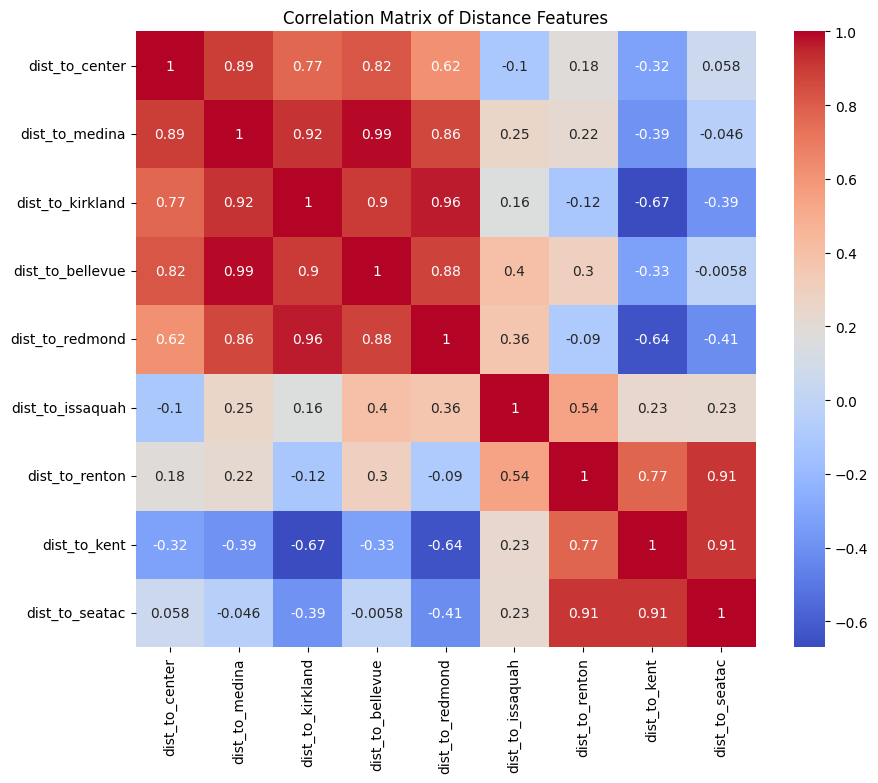

In [ ]:
# Matrix correlation of previous distances

dist_cols = ["dist_to_center", "dist_to_medina", "dist_to_kirkland", "dist_to_bellevue", "dist_to_redmond", "dist_to_issaquah", "dist_to_renton", "dist_to_kent", "dist_to_seatac"]
corr_matrix = df[dist_cols].corr()

plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm")
plt.title("Correlation Matrix of Distance Features")
plt.show()

We can see that a lot of dist are are highly linearly correlated with each other. This is probably caused by their proximity.

In [ ]:
# --- VIF (Variance Inflation Factor)

sel_vif = df.select_dtypes(include=np.number)
vif_data = pd.DataFrame()
vif_data["feature"] = sel_vif.columns
vif_data["VIF"] = [variance_inflation_factor(sel_vif.values, i) for i in range(len(sel_vif.columns))]
print(vif_data)

/usr/local/lib/python3.11/dist-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


                feature          VIF
0                    id     3.689150
1                 price     4.932564
2              bedrooms     1.814082
3             bathrooms     3.450085
4           sqft_living          inf
5              sqft_lot     3.479170
6                floors     9.761434
7            waterfront     1.332184
8                  view     1.517581
9             condition     1.310692
10                grade     3.889205
11           sqft_above          inf
12        sqft_basement          inf
13             yr_built    37.328104
14         yr_renovated     6.522927
15                  lat    42.177845
16                 long    22.289442
17        sqft_living15    14.879591
18           sqft_lot15     2.959706
19            sale_year     1.172184
20           sale_month     1.489260
21     days_since_start     1.651154
22  ratio_living_size15     9.188926
23     ratio_lot_size15     1.708355
24     living_lot_ratio     2.846945
25               volume    31.071636
2

From the VIF values, we can observe that some features have VERY high values. The choice of which variables to keep will be made subsequently by the ElasticNet model (for linear regression) and by RFECV (Random Forest) for non-linear models.

## Clustering Proceses

For this part, I decided to try 3 different clustering methods:

*   K-Means,
*   DBSCAN,
*   Gaussian mixture models (GMM)


In [ ]:
# --- Geographic Preprocessing

# We will use a single, projected coordinate system (UTM Zone 10N for King County) for all clustering algorithms to ensure they are comparable in the results.
# The output units will be in meters.
transformer = Transformer.from_crs("epsg:4326", "epsg:32610", always_xy=True)   # epsg:4326 -> lat and long in original data ||| epsg:32610 -> UTM Zone 10N
xx, yy = transformer.transform(df["long"].values, df["lat"].values)

X_geo_utm = pd.DataFrame({"easting": xx, "northing": yy}, index=df.index)       # DataFrame input for all the models

print("Data prepared for all clustering methods using UTM projection:")
print(X_geo_utm.head())

Data prepared for all clustering methods using UTM projection:
         easting      northing
0  555945.841580  5.262242e+06
1  551072.719321  5.285516e+06
2  557503.790457  5.287454e+06
3  545697.119225  5.263220e+06
4  571764.358413  5.274152e+06


### K-Means

In [ ]:
# --- K-means doesnt require assumpion or special tuning. we can already find the Silhouette, Calinski-Harabasz, and Davies-Bouldin Scores

k_range = range(2, 31)                                                          # Can be chosen from 2 to 30 cluster

silhouette_scores = []
calinski_harabasz_scores = []
davies_bouldin_scores = []

print("Calculating k-means metrics.")
for k in k_range:
    kmeans = KMeans(n_clusters=k,
                    init="k-means++",                                           # Non-random initial center position
                    random_state=42,
                    n_init=10)                                                  # Run 10 times independently with different random starting points for the cluster centers

    kmeans.fit(X_geo_utm)                                                       # actual fit
    labels = kmeans.labels_

    # Calculate Silhouette Score (highter better)
    sil_score = silhouette_score(X_geo_utm, labels)
    silhouette_scores.append(sil_score)

    # Calculate Calinski-Harabasz Score (highter better)
    ch_score = calinski_harabasz_score(X_geo_utm, labels)
    calinski_harabasz_scores.append(ch_score)

    # Calculate Davies-Bouldin Score (lower better)
    db_score = davies_bouldin_score(X_geo_utm, labels)
    davies_bouldin_scores.append(db_score)

print("Calculation complete.")

Calculating k-means metrics.
Calculation complete.


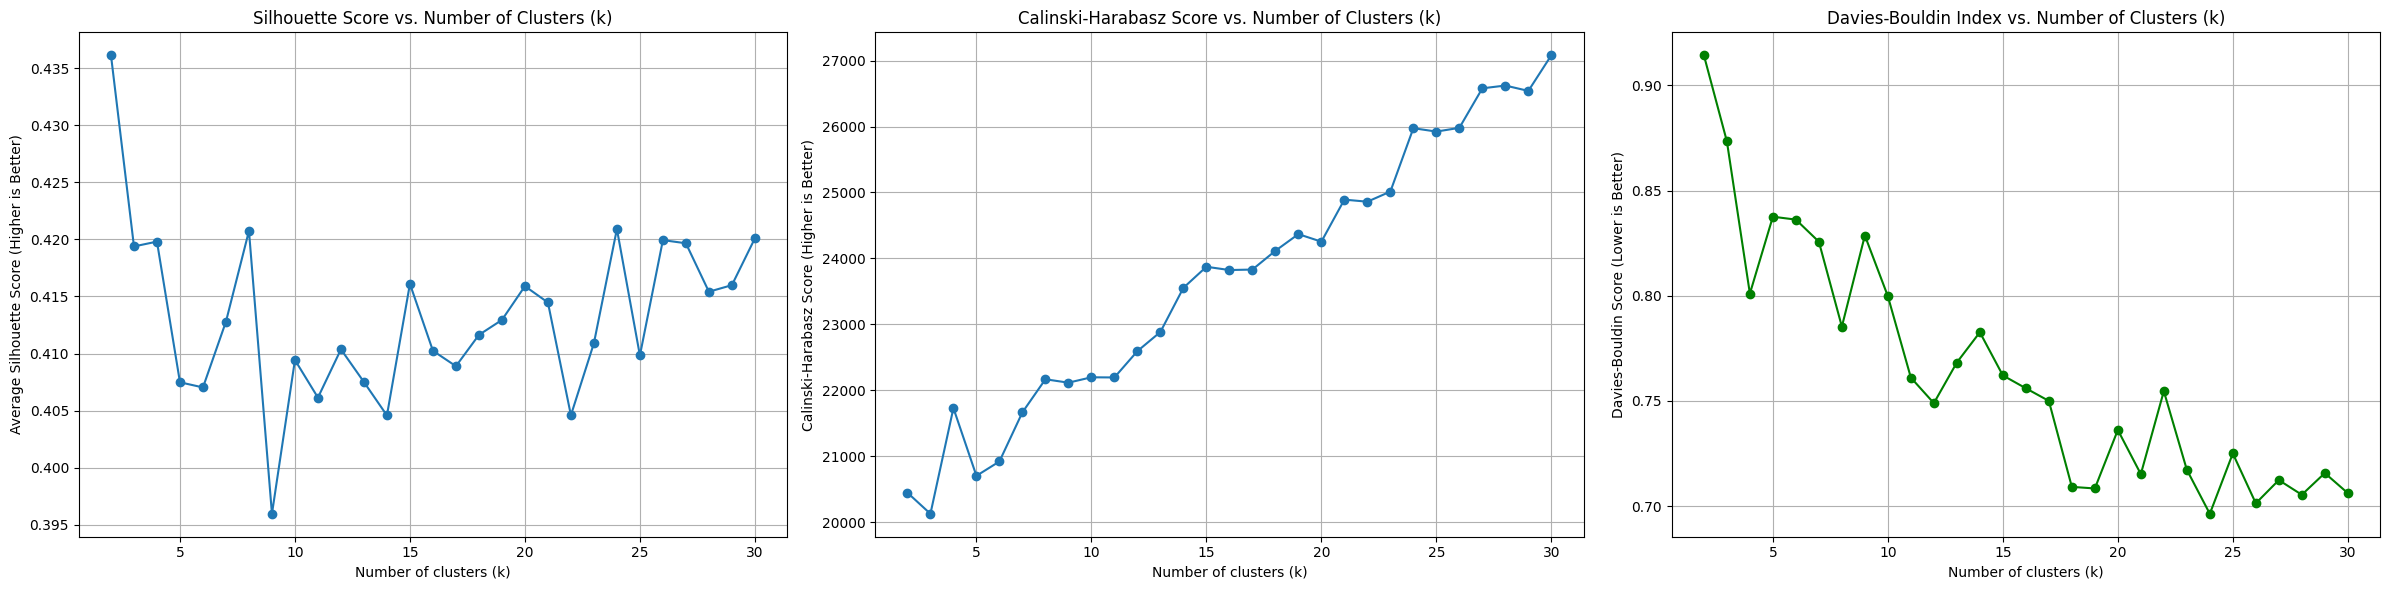

In [ ]:
# --- Plot the results

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 6))

# Plot Silhouette Scores
ax1.plot(k_range, silhouette_scores, marker="o")
ax1.set_title("Silhouette Score vs. Number of Clusters (k)")
ax1.set_xlabel("Number of clusters (k)")
ax1.set_ylabel("Average Silhouette Score (Higher is Better)")
ax1.grid(True)

# Plot Calinski-Harabasz Scores
ax2.plot(k_range, calinski_harabasz_scores, marker="o")
ax2.set_title("Calinski-Harabasz Score vs. Number of Clusters (k)")
ax2.set_xlabel("Number of clusters (k)")
ax2.set_ylabel("Calinski-Harabasz Score (Higher is Better)")
ax2.grid(True)

# --- New Plot for Davies-Bouldin
ax3.plot(k_range, davies_bouldin_scores, marker="o", color="green")
ax3.set_title("Davies-Bouldin Index vs. Number of Clusters (k)")
ax3.set_xlabel("Number of clusters (k)")
ax3.set_ylabel("Davies-Bouldin Score (Lower is Better)")
ax3.grid(True)

plt.tight_layout()
plt.show()

From these plots we can observe that 8 is an optial value for the number of cluster of the K-Means

In [ ]:
# --- Apply K-Means and Create the Feature
# After the "exploratory phase" we have selected k and we can create the new feature

optimal_k = 8
kmeans = KMeans(n_clusters=optimal_k,
                init="k-means++",
                random_state=42,
                n_init=10)

df["kmeans_cluster"] = kmeans.fit_predict(X_geo_utm)                            # <- kmeans_cluster feature is created!!! (fit and assign)

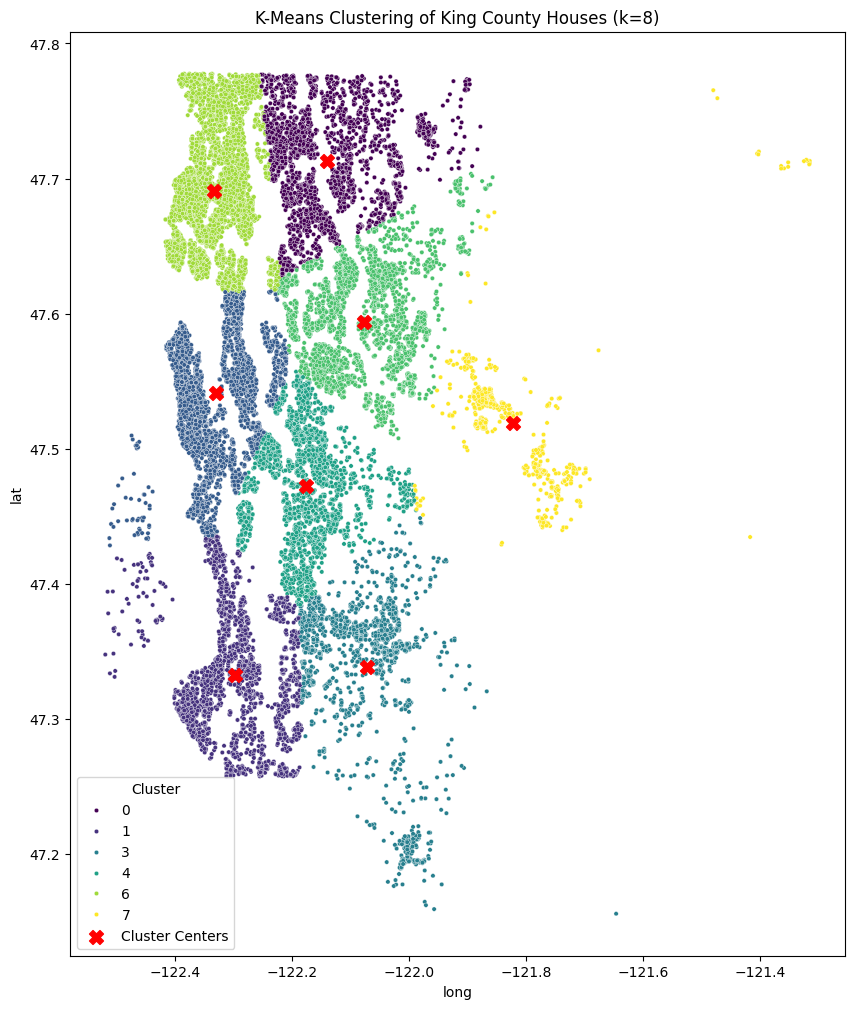

In [ ]:
# --- Visualization
# We visualize on the original lat/long, but color by the new cluster labels

plt.figure(figsize=(12, 12))
ax = plt.gca()
sns.scatterplot(data=df, x="long", y="lat", hue="kmeans_cluster", palette="viridis", s=10, ax=ax)

# Add cluster centers
inverse_transformer = Transformer.from_crs("epsg:32610", "epsg:4326", always_xy=True)
kmeans_centers_proj = kmeans.cluster_centers_
kmeans_centers_orig = inverse_transformer.transform(kmeans_centers_proj[:, 0], kmeans_centers_proj[:, 1])
ax.scatter(kmeans_centers_orig[0], kmeans_centers_orig[1], c="red", s=100, marker="X", label="Cluster Centers")

plt.title(f"K-Means Clustering of King County Houses (k={optimal_k})")
plt.legend(title="Cluster")
plt.show()

### DBSCAN

In [ ]:
# --- DBSCAN need to tune "eps". To do so, we have to first find the nearestneighbors

# Let's try a different k to see if we get a good defined "knee" in the k-distance graph.
nn5 = NearestNeighbors(n_neighbors=5)
nn10 = NearestNeighbors(n_neighbors=10)
nn15 = NearestNeighbors(n_neighbors=15)

neighbors5 = nn5.fit(X_geo_utm)                                                 # Fit the NearestNeighbors model to the data
neighbors10 = nn10.fit(X_geo_utm)
neighbors15 = nn15.fit(X_geo_utm)


distances5, indices5 = neighbors5.kneighbors(X_geo_utm)                         # Arrays of the distances and indices of 5 nearest neighbors
distances10, indices10 = neighbors10.kneighbors(X_geo_utm)                      # Arrays of the distances and indices of 10 nearest neighbors
distances15, indices15 = neighbors15.kneighbors(X_geo_utm)                      # Arrays of the distances and indices of 15 nearest neighbors

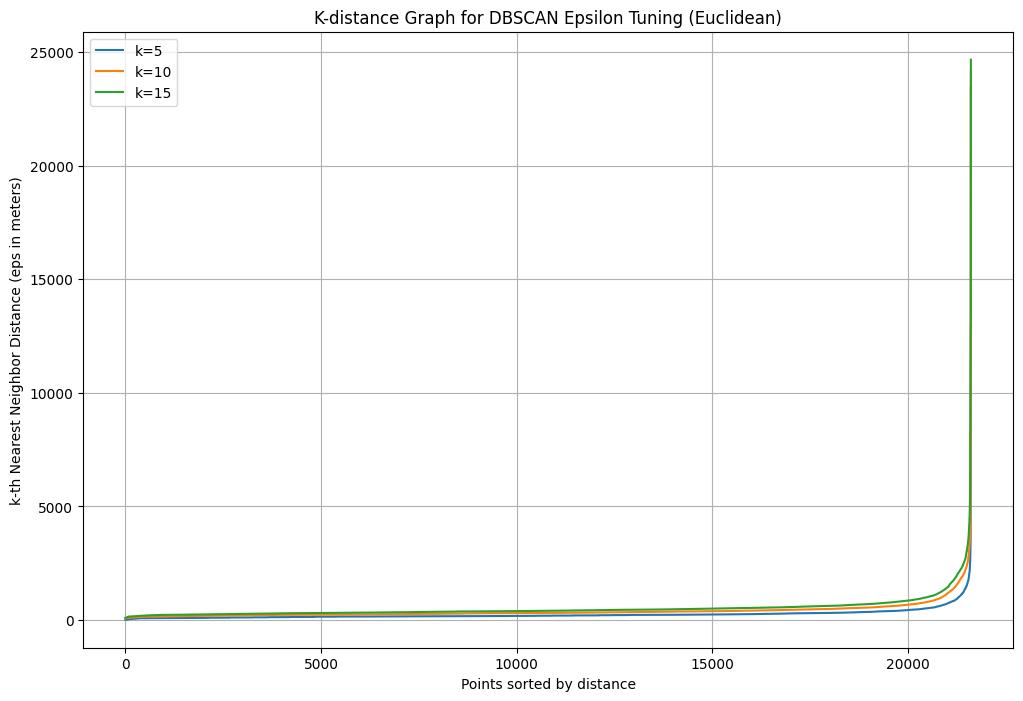

In [ ]:
# --- We need to find the range for a good eps values of the DBSCAN algorithm. The following plot is all we need!

# Sort and plot the distances for k=5, 10, and 15
distances5_sorted = np.sort(distances5[:, 4], axis=0)
distances10_sorted = np.sort(distances10[:, 9], axis=0)
distances15_sorted = np.sort(distances15[:, 14], axis=0)

plt.figure(figsize=(12, 7))
plt.plot(distances5_sorted, label="k=5")
plt.plot(distances10_sorted, label="k=10")
plt.plot(distances15_sorted, label="k=15")
plt.title("K-distance Graph for DBSCAN Epsilon Tuning (Euclidean)")
plt.xlabel("Points sorted by distance")
plt.ylabel("k-th Nearest Neighbor Distance (eps in meters)")
plt.legend()
plt.grid(True)
plt.show()

The "knee" for k=15 is the most well-defined, and it appears to be in the range of 500 to 3000 meters.

Based on this, k=15 will be used and test eps values in the range of 500 to 3000 meters in the DBSCAN tuning loop.


In [ ]:
# --- Test the range of eps valus to find the best one for your DBSCAN model

eps_range = np.linspace(500, 3000, 40)

silhouette_scores_dbscan = []
calinski_harabasz_scores_dbscan = []
davies_bouldin_scores_dbscan = []

print("DBSCAN clustering for different eps values.")
for eps in eps_range:
    dbscan = DBSCAN(eps=eps,
                    min_samples=15)                                             # We seleced k=15
    labels = dbscan.fit_predict(X_geo_utm)

    # Exclude outliers for metric calculation (where the label is -1).
    mask = labels != -1
    if len(set(labels[mask])) > 1:                                              # Checks if there is more than one cluster found.
        silhouette_scores_dbscan.append(silhouette_score(X_geo_utm[mask], labels[mask]))
        calinski_harabasz_scores_dbscan.append(calinski_harabasz_score(X_geo_utm[mask], labels[mask]))
        davies_bouldin_scores_dbscan.append(davies_bouldin_score(X_geo_utm[mask], labels[mask]))
    else:                                                                       # If only one cluster is found (or none) -> non applicable metrics
        silhouette_scores_dbscan.append(np.nan)
        calinski_harabasz_scores_dbscan.append(np.nan)
        davies_bouldin_scores_dbscan.append(np.nan)

print("Calculation complete.")

DBSCAN clustering for different eps values.
Calculation complete.


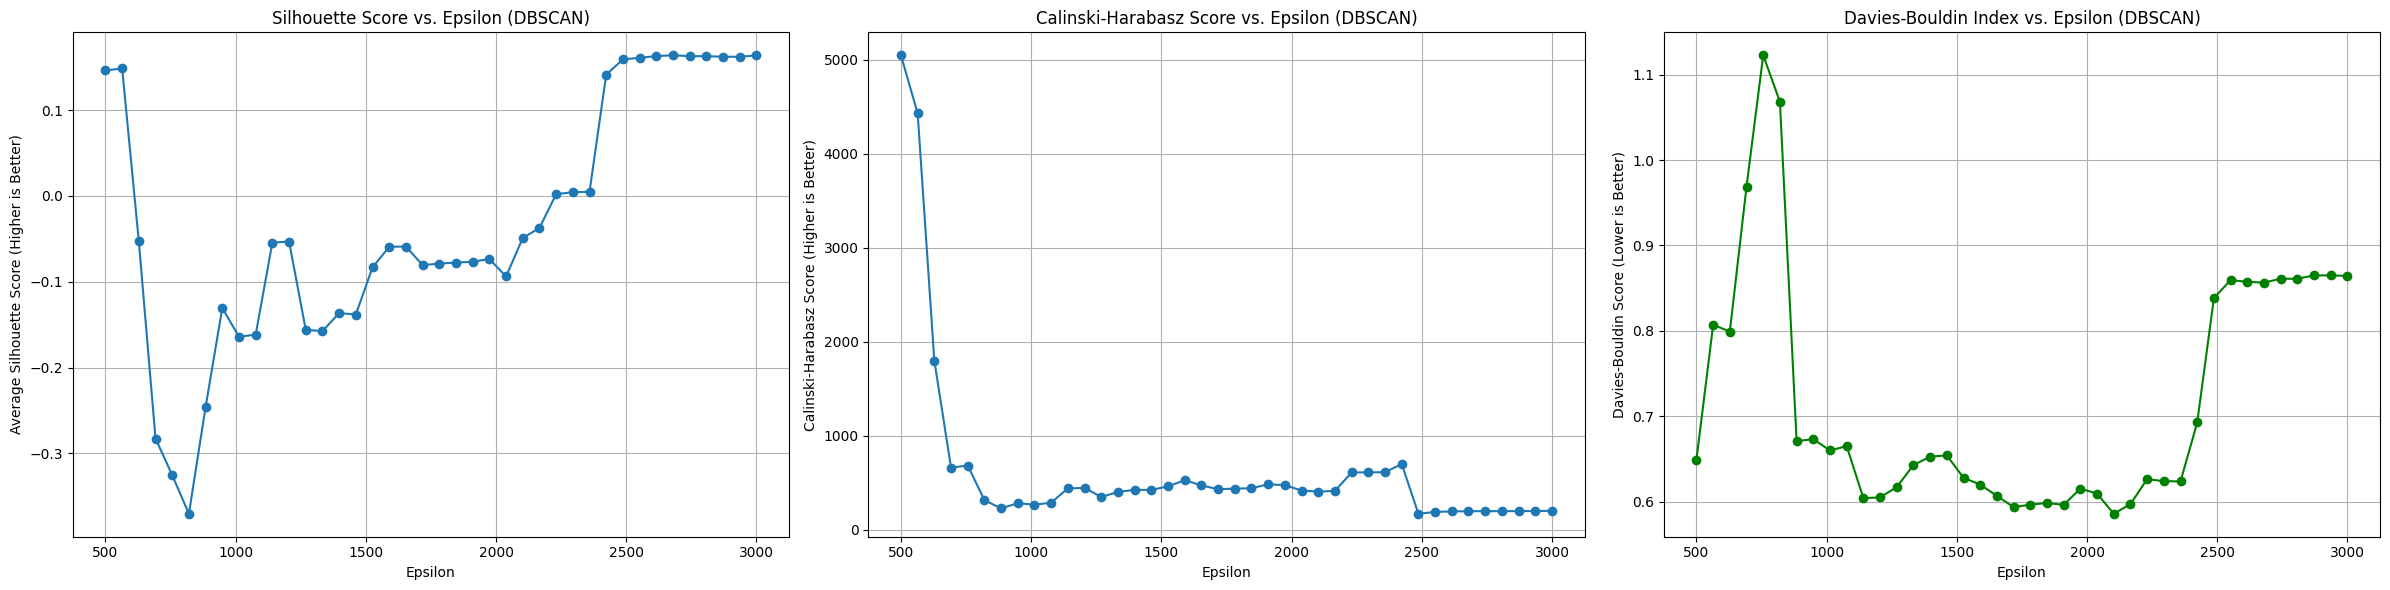

In [ ]:
# --- Plot the results

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 6))

# Plot Silhouette Scores
ax1.plot(eps_range, silhouette_scores_dbscan, marker="o")
ax1.set_title("Silhouette Score vs. Epsilon (DBSCAN)")
ax1.set_xlabel("Epsilon")
ax1.set_ylabel("Average Silhouette Score (Higher is Better)")
ax1.grid(True)

# Plot Calinski-Harabasz Scores
ax2.plot(eps_range, calinski_harabasz_scores_dbscan, marker="o")
ax2.set_title("Calinski-Harabasz Score vs. Epsilon (DBSCAN)")
ax2.set_xlabel("Epsilon")
ax2.set_ylabel("Calinski-Harabasz Score (Higher is Better)")
ax2.grid(True)

# Plot Davies-Bouldin Scores
ax3.plot(eps_range, davies_bouldin_scores_dbscan, marker="o", color="green")
ax3.set_title("Davies-Bouldin Index vs. Epsilon (DBSCAN)")
ax3.set_xlabel("Epsilon")
ax3.set_ylabel("Davies-Bouldin Score (Lower is Better)")
ax3.grid(True)

plt.tight_layout()
plt.show()

From these plots we can observe that 2300 is an optial value for the eps

In [ ]:
# --- Apply DBSCAN to the dataset

optimal_eps = 2300

dbscan = DBSCAN(eps=optimal_eps,
                min_samples=5)

df["dbscan_cluster"] = dbscan.fit_predict(X_geo_utm)

# The cluster label "-1" is for outliers/noise.
print(f"Number of clusters found: {len(set(dbscan.labels_)) - (1 if -1 in dbscan.labels_ else 0)}")
print(f"Number of outliers: {list(dbscan.labels_).count(-1)}")

Number of clusters found: 4
Number of outliers: 12


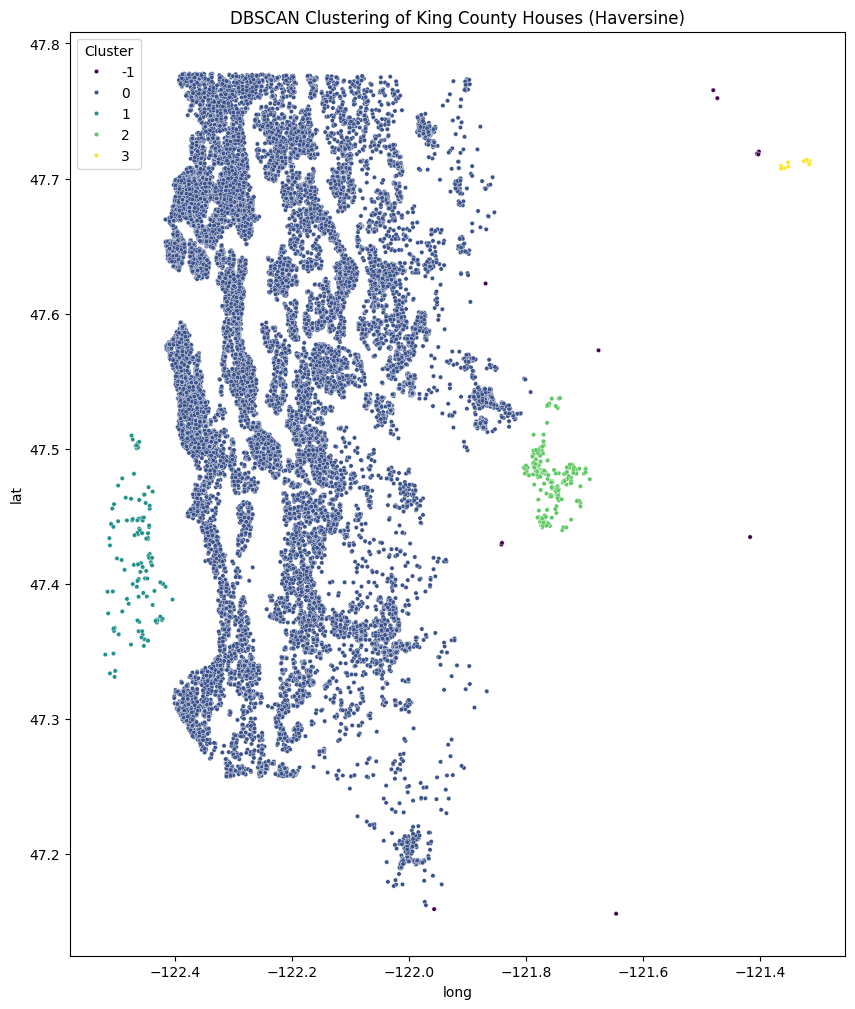

In [ ]:
# --- DBSCAN visualization

plt.figure(figsize=(12, 12))
sns.scatterplot(data=df, x="long", y="lat", hue="dbscan_cluster", palette="viridis", s=10)
plt.title("DBSCAN Clustering of King County Houses (Haversine)")
plt.legend(title="Cluster")
plt.show()

This is a really interesting plot... the metric values indicate that DBSCAN doesn't work particularly well with Silhouette and Calinski-Harabasz. This is most likely caused by the giant main cluster that indicates (in dark blue) the entire urban and suburban area of Seattle. The Davies-Bouldin score, however, "shows" us that the separation from clusers is very effective, thus correctly finding the areas outside the main urban area.

### Gaussian mixture models (GMM)

In [ ]:
# --- find the best GMM model

# We will try different combination of the number of clusters and the covariance type
n_components_range = range(2, 30)                                               # A good range to test

covariance_types = [                                                            # Covariance type
    "spherical",                                                                # Each cluster has the same, spherical shape.
    "diag",                                                                     # Each cluster is an ellipse aligned with the axes
    "tied",                                                                     # All clusters have the same elliptical shape
    "full"]                                                                     # Each cluster can have its own, arbitrarily oriented elliptical shape.

ggm_result = []

print("Start GMM analysis")
for cov_type in covariance_types:
    for n_components in n_components_range:
        gmm = GaussianMixture(n_components=n_components,                        # nummber of cluster
                              covariance_type=cov_type,                         # covariance type
                              random_state=42)

        gmm.fit(X_geo_utm)                                                      # fit
        labels = gmm.predict(X_geo_utm)

        ggm_result.append({                                                     # store the results
            "n_components": n_components,
            "covariance_type": cov_type,
            "bic": gmm.bic(X_geo_utm),
            "aic": gmm.aic(X_geo_utm),
            "silhouette": silhouette_score(X_geo_utm, labels),
            "calinski_harabasz": calinski_harabasz_score(X_geo_utm, labels),
            "davies_bouldin": davies_bouldin_score(X_geo_utm, labels),
        })

print("Analysis complete.")

Start GMM analysis
Analysis complete.


In [ ]:
# ---  From raw results to dataframe for better analysis

results_df = pd.DataFrame(ggm_result)
results_df

n_components covariance_type            bic            aic  silhouette  \
0               2       spherical  936587.873648  936532.006296    0.436933   
1               3       spherical  935103.375418  935015.583865    0.415478   
2               4       spherical  931365.200054  931245.484300    0.376730   
3               5       spherical  930906.310686  930754.670731    0.402849   
4               6       spherical  930089.934862  929906.370706    0.395522   
..            ...             ...            ...            ...         ...   
107            25            full  915701.702668  914512.526178    0.374910   
108            26            full  915190.327619  913953.264828    0.367055   
109            27            full  915416.671156  914131.722064    0.375020   
110            28            full  915224.005014  913891.169619    0.356392   
111            29            full  915232.017953  913851.296257    0.388879   

     calinski_harabasz  davies_bouldin  
0         20207.715784        0.920810  
1         19509.626444        0.848339  
2         18770.738972        0.791374  
3         20121.777672        0.818053  
4         20033.927831        0.792050  
..                 ...             ...  
107       18604.198310        1.038462  
108       18699.006460        0.868693  
109       19901.824920        0.842695  
110       17494.229205        1.098801  
111       20455.414061        0.827929  

[112 rows x 7 columns]

In [ ]:
# --- Displaying the BIC and AIC results (similar to an R output...) (I like R)

print("\nBIC Scores (Lower is better)")
bic_pivot = results_df.pivot(index="n_components", columns="covariance_type", values="bic")
print(bic_pivot)


print("\nAIC Scores (Lower is better)")
aic_pivot = results_df.pivot(index="n_components", columns="covariance_type", values="aic")
print(aic_pivot)


BIC Scores (Lower is better)
covariance_type           diag           full      spherical           tied
n_components                                                               
2                936602.879594  936194.695873  936587.873648  937233.042140
3                932184.325542  931418.798143  935103.375418  935279.107552
4                931572.660967  929985.957590  931365.200054  933481.498937
5                929571.443524  929185.260132  930906.310686  933079.804127
6                928934.242523  927780.688591  930089.934862  932253.110843
7                927013.691440  926271.363060  929517.319024  930539.634099
8                925882.765667  925375.723774  927975.926811  930550.142558
9                926032.747375  923843.571471  928601.262087  929794.031936
10               924697.887604  921392.516961  926482.190768  929559.314882
11               924804.894056  921087.916653  925837.176570  928222.038991
12               924136.448399  923681.630292  925547.9957

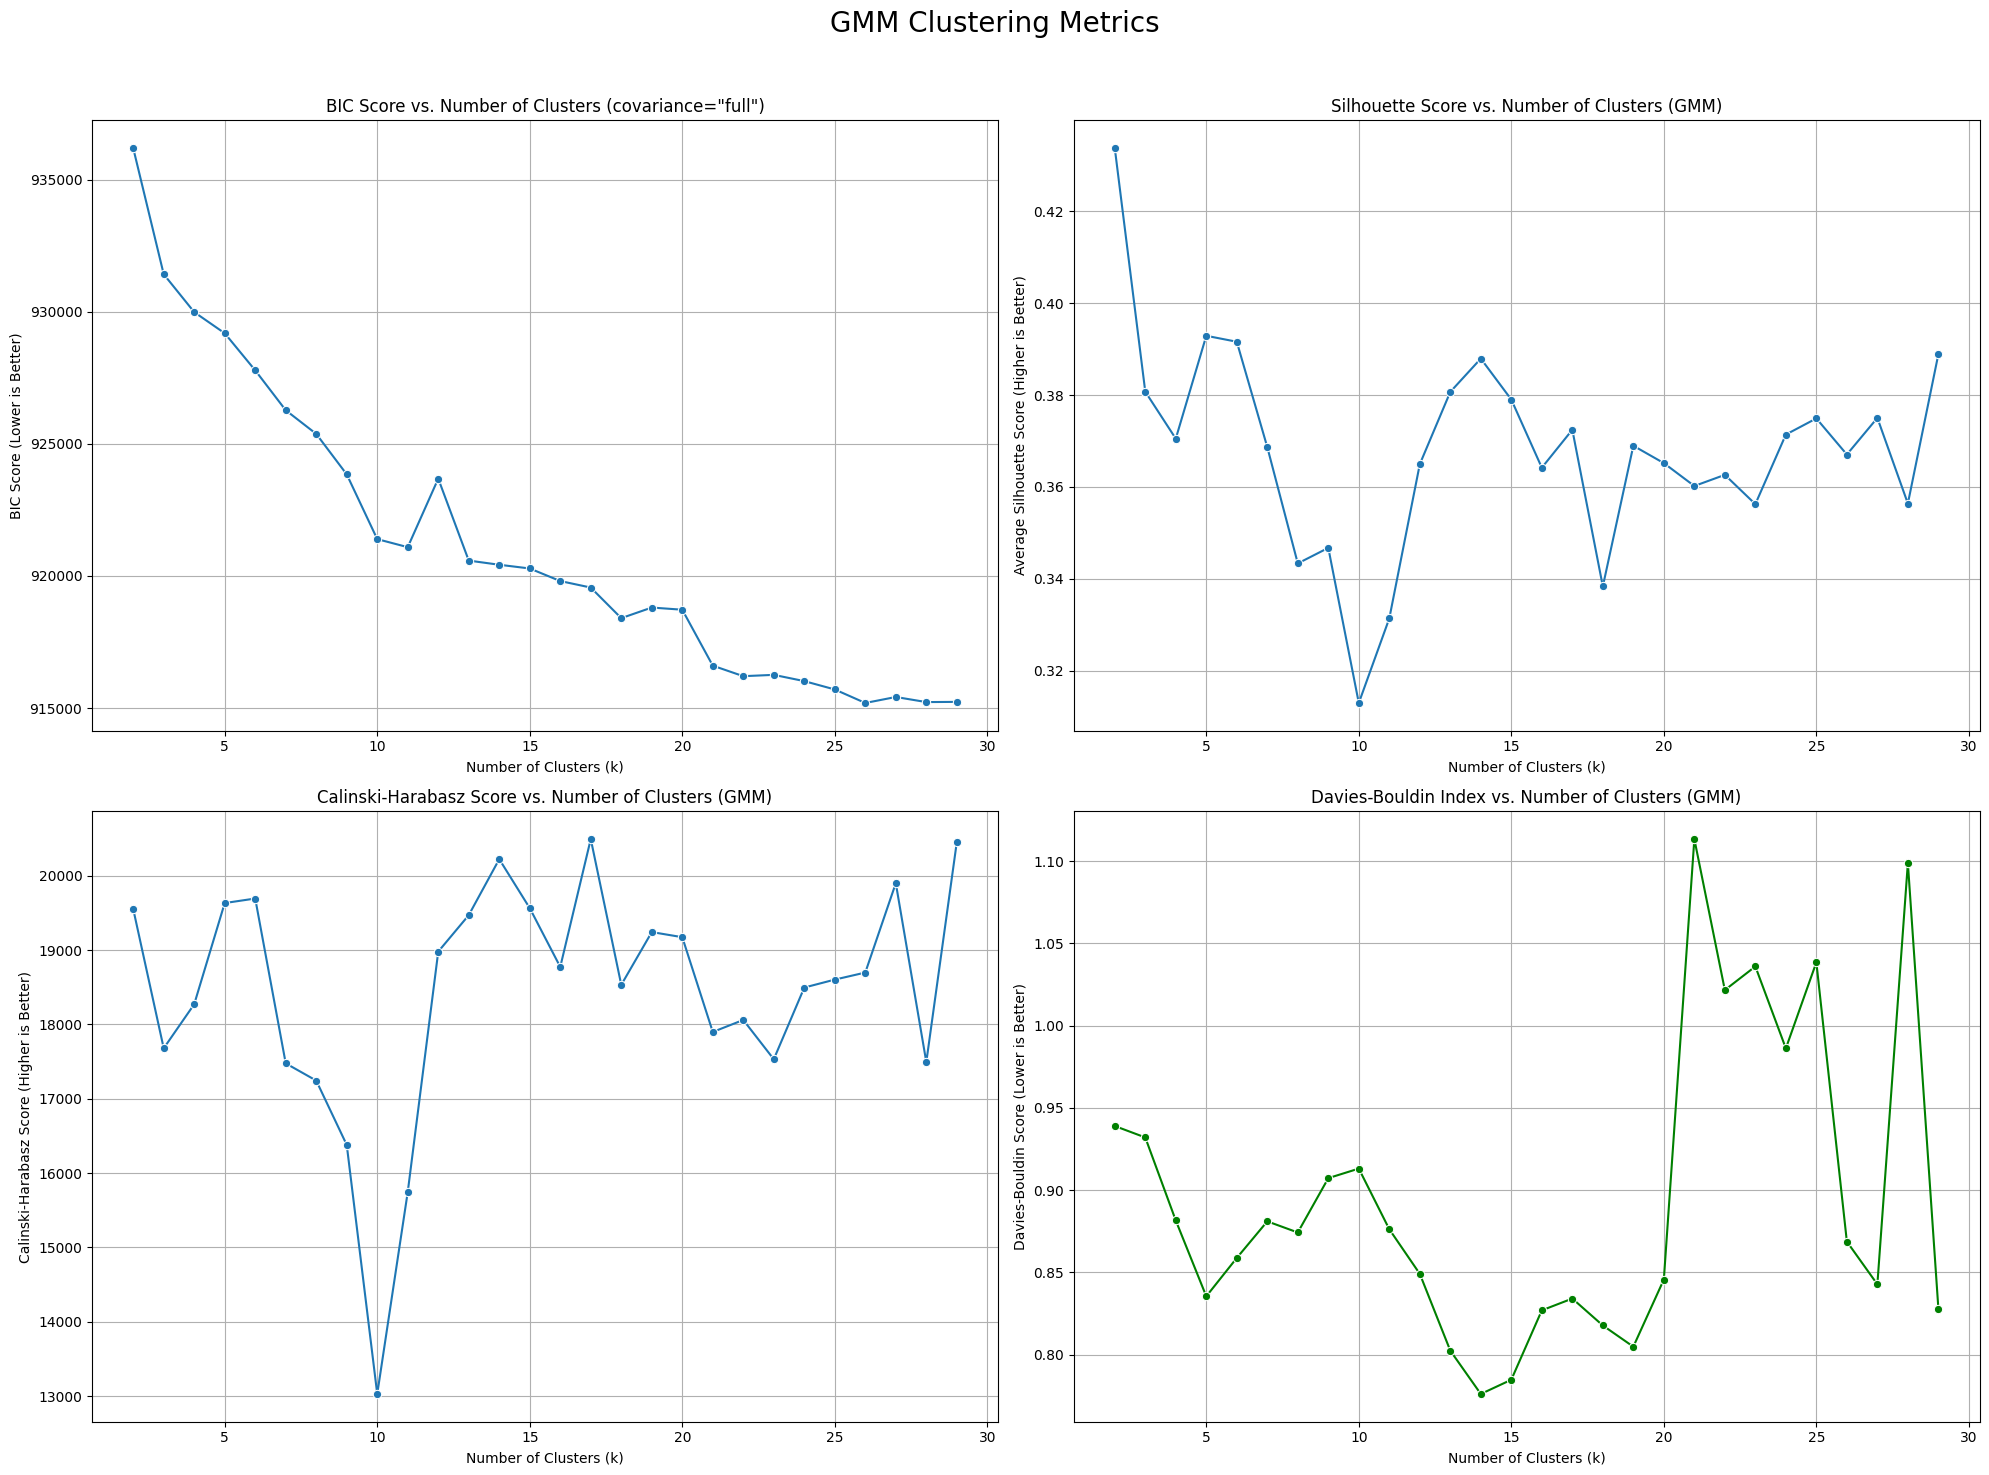

In [ ]:
# --- GMM Score Plots

fig, axes = plt.subplots(2, 2, figsize=(20, 15))
fig.suptitle("GMM Clustering Metrics", fontsize=20)

# BIC Plot

best_model = results_df.loc[results_df["bic"].idxmin()]
best_cov_type = best_model["covariance_type"]

plot_data = results_df[results_df["covariance_type"] == best_cov_type]
sns.lineplot(data=plot_data, x="n_components", y="bic", marker="o", ax=axes[0, 0])
axes[0, 0].set_title(f"BIC Score vs. Number of Clusters (covariance=\"{best_cov_type}\")")
axes[0, 0].set_xlabel("Number of Clusters (k)")
axes[0, 0].set_ylabel("BIC Score (Lower is Better)")
axes[0, 0].grid(True)


# Silhouette Score Plot
sns.lineplot(data=plot_data, x="n_components", y="silhouette", marker="o", ax=axes[0, 1])
axes[0, 1].set_title("Silhouette Score vs. Number of Clusters (GMM)")
axes[0, 1].set_xlabel("Number of Clusters (k)")
axes[0, 1].set_ylabel("Average Silhouette Score (Higher is Better)")
axes[0, 1].grid(True)


# Calinski-Harabasz Score Plot
sns.lineplot(data=plot_data, x="n_components", y="calinski_harabasz", marker="o", ax=axes[1, 0])
axes[1, 0].set_title("Calinski-Harabasz Score vs. Number of Clusters (GMM)")
axes[1, 0].set_xlabel("Number of Clusters (k)")
axes[1, 0].set_ylabel("Calinski-Harabasz Score (Higher is Better)")
axes[1, 0].grid(True)


# Davies-Bouldin Score Plot
sns.lineplot(data=plot_data, x="n_components", y="davies_bouldin", marker="o", color="green", ax=axes[1, 1])
axes[1, 1].set_title("Davies-Bouldin Index vs. Number of Clusters (GMM)")
axes[1, 1].set_xlabel("Number of Clusters (k)")
axes[1, 1].set_ylabel("Davies-Bouldin Score (Lower is Better)")
axes[1, 1].grid(True)


plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

From these plots we can observe that 14 is an optial value for the number of cluster of the GMM

In [ ]:
# --- Best model based on BIC

best_model_bic = results_df.loc[results_df["bic"].idxmin()]
print(f"\nBest model according to BIC:\n{best_model_bic}")


Best model according to BIC:
n_components                    26
covariance_type               full
bic                  915190.327619
aic                  913953.264828
silhouette                0.367055
calinski_harabasz      18699.00646
davies_bouldin            0.868693
Name: 108, dtype: object


Covariance_type="full" allows for complex cluster shapes, it gives the GMM power to fit the data very precisely. From the previous graph, we can see that after 10 clusters, the reduction in BIC decreases continuously less and less (the last 9 increases lead to a reduction of about 100 in the BIC value). For this reason, and observing the behavior of the max and min of the other indices, I decide to take k = 14 as the optimal number of clusters.

In [ ]:
# --- Manual Selection + Fit

best_n_components_gmm = 14                                                      # Manually selected
best_cov_type_gmm = "full"                                                      # From the previous table, we can see that for k=16 the best cov is "full"

best_gmm = GaussianMixture(n_components=best_n_components_gmm,
                             covariance_type=best_cov_type_gmm,
                             random_state=42)

best_gmm.fit(X_geo_utm)

GaussianMixture(n_components=14, random_state=42)

In [ ]:
# --- Apply the Best GMM and Create Features
# GMM has the "power" to do hard and soft cluster. Let's create both for "test" (we will keep only one later)

# 1. Hard Clustering
df["gmm_cluster"] = best_gmm.predict(X_geo_utm)                                 # New feature of the cluster label

# 2. Soft Clustering (KEY ADVANTAGE OF GMM)
cluster_probabilities = best_gmm.predict_proba(X_geo_utm)                       # Probability that the house belongs to each of the clusters
prob_df = pd.DataFrame(cluster_probabilities,                                   # New dataframe with the prob
                       columns=[f"gmm_prob_{i}" for i in range(best_gmm.n_components)],
                       index=df.index)

# Robustly join the new features, removing old ones if they exist
cols_to_drop = df.filter(like="gmm_prob_").columns                              # If run multiple time GMM
df = df.drop(columns=cols_to_drop).join(prob_df)                                # add new prob to the orginal dataset

print("\nNew features created:")
print(df.filter(regex="gmm_").head())


New features created:
   gmm_cluster    gmm_prob_0    gmm_prob_1    gmm_prob_2  gmm_prob_3  \
0           12  1.292818e-13  1.741700e-14  3.532019e-08    0.039192   
1            1  1.087632e-19  4.947423e-01  2.113036e-32    0.000074   
2            4  4.073040e-11  9.128725e-03  4.884375e-36    0.001963   
3            5  2.706988e-31  5.210953e-09  2.154386e-08    0.000017   
4            0  9.012745e-01  1.153674e-19  1.025292e-22    0.086796   

     gmm_prob_4     gmm_prob_5    gmm_prob_6     gmm_prob_7    gmm_prob_8  \
0  2.660315e-10   2.853055e-12  3.650099e-01   1.468554e-66  3.903381e-30   
1  1.654729e-02   2.658813e-29  3.304289e-09  2.426589e-153  4.861263e-01   
2  7.766391e-01   8.642925e-68  1.653997e-09  1.648695e-141  2.053412e-01   
3  7.807453e-15   8.782855e-01  1.216171e-01  1.452829e-105  2.380068e-30   
4  1.862434e-03  1.563990e-146  4.659146e-07   7.016304e-73  5.638167e-18   

     gmm_prob_9   gmm_prob_10   gmm_prob_11    gmm_prob_12   gmm_prob_13  
0  1.8

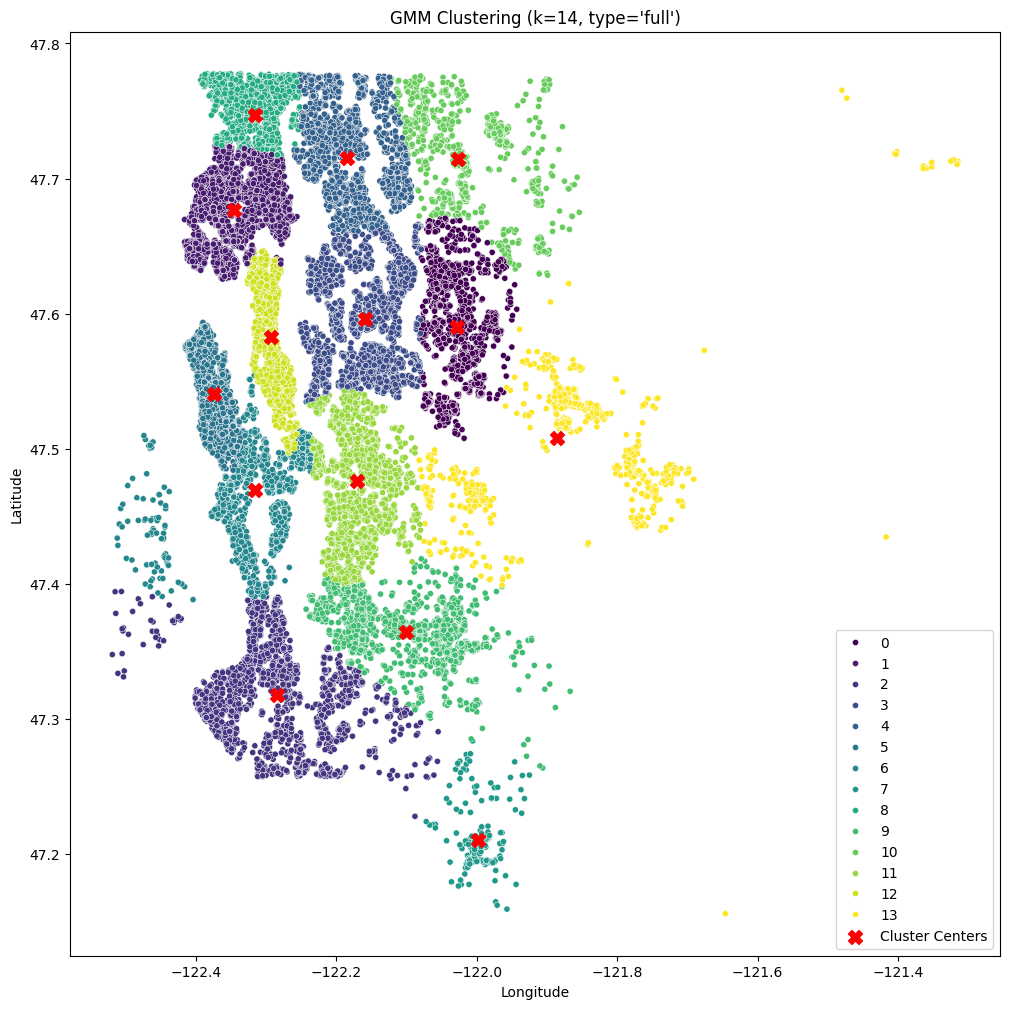

In [ ]:
# --- Visualize GMM

plt.figure(figsize=(12, 12))
ax = plt.gca()
sns.scatterplot(data=df, x="long", y="lat", hue="gmm_cluster", palette="viridis", s=20, ax=ax, legend="full")

# Add cluster centers
inverse_transformer = Transformer.from_crs("epsg:32610", "epsg:4326", always_xy=True)
original_centers = inverse_transformer.transform(best_gmm.means_[:, 0], best_gmm.means_[:, 1])

ax.scatter(original_centers[0], original_centers[1], c="red", s=100, marker="X", label="Cluster Centers")
plt.title(f"GMM Clustering (k={best_gmm.n_components}, type='{best_gmm.covariance_type}')")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend()
plt.show()

In [ ]:
# --- FINAL MODEL COMPARISON TABLE
dbscan_idx = (np.abs(eps_range - optimal_eps)).argmin()
gmm_metrics_row = results_df[(results_df["n_components"] == best_n_components_gmm) & (results_df["covariance_type"] == best_cov_type_gmm)]


cluster_models = [
    ("K-Means (k=8)", {
        "Silhouette Score": silhouette_scores[optimal_k - list(k_range).index(2)],
        "Calinski-Harabasz Score": calinski_harabasz_scores[optimal_k - list(k_range).index(2)],
        "Davies-Bouldin Score": davies_bouldin_scores[optimal_k - list(k_range).index(2)]
    }),
    ("DBSCAN (eps=2300, min_samples=15)", {
        "Silhouette Score": silhouette_scores_dbscan[dbscan_idx],
        "Calinski-Harabasz Score": calinski_harabasz_scores_dbscan[dbscan_idx],
        "Davies-Bouldin Score": davies_bouldin_scores_dbscan[dbscan_idx]
    }),
    ("GMM (k=14, cov='full')", {
        "Silhouette Score": gmm_metrics_row["silhouette"].iloc[0],
        "Calinski-Harabasz Score": gmm_metrics_row["calinski_harabasz"].iloc[0],
        "Davies-Bouldin Score": gmm_metrics_row["davies_bouldin"].iloc[0],
        "BIC Score": gmm_metrics_row["bic"].iloc[0]
    })
]

# Create the comparison DataFrame
comparison_df = pd.DataFrame({name: metrics for name, metrics in cluster_models}).T

# Print
print("\n--- FINAL CLUSTERING MODEL COMPARISON ---")
print("Metrics Interpretation:")
print("- Silhouette Score: Higher is better (range -1 to 1)")
print("- Calinski-Harabasz Score: Higher is better (no fixed range)")
print("- Davies-Bouldin Score: Lower is better (min 0, no fixed upper bound)")
print("- BIC Score (GMM only): Lower is better (no fixed range)")
print("\n" + comparison_df.to_string())


--- FINAL CLUSTERING MODEL COMPARISON ---
Metrics Interpretation:
- Silhouette Score: Higher is better (range -1 to 1)
- Calinski-Harabasz Score: Higher is better (no fixed range)
- Davies-Bouldin Score: Lower is better (min 0, no fixed upper bound)
- BIC Score (GMM only): Lower is better (no fixed range)

                                   Silhouette Score  Calinski-Harabasz Score  Davies-Bouldin Score      BIC Score
K-Means (k=8)                              0.409439             22197.791753              0.799792            NaN
DBSCAN (eps=2300, min_samples=15)          0.004366               608.466620              0.624235            NaN
GMM (k=14, cov='full')                     0.387922             20224.951128              0.776039  920422.575319


At the end of this process, I choose to "carry forward" the GMM and DBSCAN models. GMM is a more flexible version of k-means, and although k-means is higher on the Silhouette and Calinski-Harabasz scores, while GMM has lower values for Davies-Bouldin, the strength of GMM is that it provides us with the probabilities that each observation belongs to a given cluster. We also "carry forward" DBSCAN for its very low Calinski-Harabasz score and its ability to determine the different areas of Seattle (as analyzed previously).

## Deleating unused features

In [ ]:
df.T

0                    1      \
id                            7129300520           6414100192   
date                 2014-10-13 00:00:00  2014-12-09 00:00:00   
price                           221900.0             538000.0   
bedrooms                               3                    3   
bathrooms                            1.0                 2.25   
sqft_living                         1180                 2570   
sqft_lot                            5650                 7242   
floors                               1.0                  2.0   
waterfront                             0                    0   
view                                   0                    0   
condition                              3                    3   
grade                                  7                    7   
sqft_above                          1180                 2170   
sqft_basement                          0                  400   
yr_built                            1955                 1951   
yr_renovated                           0                 1991   
zipcode                            98178                98125   
lat                              47.5112               47.721   
long                            -122.257             -122.319   
sqft_living15                       1340                 1690   
sqft_lot15                          5650                 7639   
sale_year                           2014                 2014   
sale_month                            10                   12   
days_since_start                     164                  221   
ratio_living_size15             0.880597              1.52071   
ratio_lot_size15                     1.0              0.94803   
living_lot_ratio                 0.20885             0.354874   
volume                            1180.0               5140.0   
age                                   60                   24   
season                              Fall               Winter   
dist_to_center                 14.043416            11.416139   
dist_to_medina                 12.398953            13.062677   
dist_to_kirkland               19.981626            10.572859   
dist_to_bellevue                11.81019            15.159712   
dist_to_redmond                20.757704             15.67701   
dist_to_issaquah                16.98019            30.186273   
dist_to_renton                  4.349483            27.558742   
dist_to_kent                    14.88338            38.627592   
dist_to_seatac                   8.47333            31.529386   
kmeans_cluster                         2                    6   
dbscan_cluster                         0                    0   
gmm_cluster                           12                    1   
gmm_prob_0                           0.0                  0.0   
gmm_prob_1                           0.0             0.494742   
gmm_prob_2                           0.0                  0.0   
gmm_prob_3                      0.039192             0.000074   
gmm_prob_4                           0.0             0.016547   
gmm_prob_5                           0.0                  0.0   
gmm_prob_6                       0.36501                  0.0   
gmm_prob_7                           0.0                  0.0   
gmm_prob_8                           0.0             0.486126   
gmm_prob_9                           0.0                  0.0   
gmm_prob_10                          0.0             0.000037   
gmm_prob_11                     0.072836                  0.0   
gmm_prob_12                     0.519978             0.002473   
gmm_prob_13                     0.002985                  0.0   

                                   2                    3      \
id                            5631500400           2487200875   
date                 2015-02-25 00:00:00  2014-12-09 00:00:00   
price                           180000.0             604000.0   
bedrooms                               2                    4   
bath

In [ ]:
# --- Columns to drop:
# id: I mean...
# date: we worked on it and we extraced the "relative" feaure
# kmeans_cluster: we will use the gmm prob
# gmm_cluster: we will use the soft clusering of gmm
# gmm_prob_0: to prevent MULTICOLLINEARITY from ElsaticNet

df.drop(columns=["id", "date", "kmeans_cluster", "gmm_cluster", "gmm_prob_0"], inplace=True)
df.T

0          1          2          3          4      \
price                 221900.0   538000.0   180000.0   604000.0   510000.0   
bedrooms                     3          3          2          4          3   
bathrooms                  1.0       2.25        1.0        3.0        2.0   
sqft_living               1180       2570        770       1960       1680   
sqft_lot                  5650       7242      10000       5000       8080   
floors                     1.0        2.0        1.0        1.0        1.0   
waterfront                   0          0          0          0          0   
view                         0          0          0          0          0   
condition                    3          3          3          5          3   
grade                        7          7          6          7          8   
sqft_above                1180       2170        770       1050       1680   
sqft_basement                0        400          0        910          0   
yr_built                  1955       1951       1933       1965       1987   
yr_renovated                 0       1991          0          0          0   
zipcode                  98178      98125      98028      98136      98074   
lat                    47.5112     47.721    47.7379    47.5208    47.6168   
long                  -122.257   -122.319   -122.233   -122.393   -122.045   
sqft_living15             1340       1690       2720       1360       1800   
sqft_lot15                5650       7639       8062       5000       7503   
sale_year                 2014       2014       2015       2014       2015   
sale_month                  10         12          2         12          2   
days_since_start           164        221        299        221        292   
ratio_living_size15   0.880597    1.52071   0.283088   1.441176   0.933333   
ratio_lot_size15           1.0    0.94803   1.240387        1.0   1.076903   
living_lot_ratio       0.20885   0.354874      0.077      0.392   0.207921   
volume                  1180.0     5140.0      770.0     1960.0     1680.0   
age                         60         24         82         50         28   
season                    Fall     Winter     Winter     Winter     Winter   
dist_to_center       14.043416  11.416139  15.740509  11.539974   22.91044   
dist_to_medina       12.398953  13.062677  13.012723  16.670251  13.695445   
dist_to_kirkland     19.981626  10.572859   6.781692  23.835736  13.133799   
dist_to_bellevue      11.81019  15.159712  14.384873  17.533739  11.691242   
dist_to_redmond      20.757704   15.67701  10.958939  26.543345   8.561064   
dist_to_issaquah      16.98019  30.186273  27.556069  27.079488    9.68505   
dist_to_renton        4.349483  27.558742  28.382122  13.872574  19.710633   
dist_to_kent          14.88338  38.627592  40.019348   19.72375  30.230873   
dist_to_seatac         8.47333  31.529386  33.594184  12.054983  27.030312   
dbscan_cluster               0          0          0          0          0   
gmm_prob_1                 0.0   0.494742   0.009129        0.0        0.0   
gmm_prob_2                 0.0        0.0        0.0        0.0        0.0   
gmm_prob_3            0.039192   0.000074   0.001963   0.000017   0.086796   
gmm_prob_4                 0.0   0.016547   0.776639        0.0   0.001862   
gmm_prob_5                 0.0        0.0        0.0   0.878286        0.0   
gmm_prob_6             0.36501        0.0        0.0   0.121617        0.0   
gmm_prob_7                 0.0        0.0        0.0        0.0        0.0   
gmm_prob_8                 0.0   0.486126   0.205341        0.0        0.0   
gmm_prob_9                 0.0        0.0        0.0        0.0        0.0   
gmm_prob_10                0.0   0.000037   0.006928        0.0   0.006151   
gmm_prob_11           0.072836        0.0        0.0        0.0   0.000005   
gmm_prob_12           0.519978   0.002473        0.0        0.0        0.0   
gmm_prob_13           0.002985        0.0      

# Feature transformation

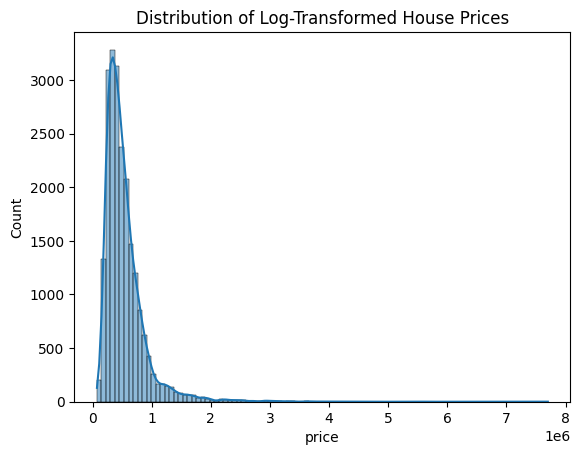

In [ ]:
# --- The distribution of the house price

plt.figure(figsize=(12, 7))
sns.histplot(df["price"], bins=100, kde=True)
plt.title("Distribution of Log-Transformed House Prices")
plt.show()

 the price distribution is  VERY right skewed. Is it the only one?

In [ ]:
# --- Skewness of all the numerical variables

skewness = df.select_dtypes(include=["number"]).skew()
print(skewness)

price                   4.024069
bedrooms                0.518528
bathrooms               0.511108
sqft_living             1.471555
sqft_lot               13.060019
floors                  0.616177
waterfront             11.385108
view                    3.395750
condition               1.032805
grade                   0.771103
sqft_above              1.446664
sqft_basement           1.577965
yr_built               -0.469805
yr_renovated            4.549493
lat                    -0.485270
long                    0.885053
sqft_living15           1.108181
sqft_lot15              9.506743
sale_year               0.757299
sale_month              0.063130
days_since_start        0.179112
ratio_living_size15     2.034754
ratio_lot_size15       31.853959
living_lot_ratio        2.375570
volume                  1.747283
age                     0.556482
dist_to_center          0.710962
dist_to_medina          1.076042
dist_to_kirkland        0.836125
dist_to_bellevue        1.047529
dist_to_re

A LOT OF numeric variables are right skewed

In [ ]:
# --- Log trasformation

# If a variable has a skewness > 1 a log trasformation will be applied
log_transformations = {
    "price": np.log,
    "sqft_living": np.log,
    "sqft_lot": np.log,
    "sqft_above": np.log,
    "sqft_basement": np.log1p,                                                  # log1p to handle possible zeros
    "sqft_living15": np.log,
    "sqft_lot15": np.log,
    "ratio_living_size15": np.log,
    "ratio_lot_size15": np.log,
    "living_lot_ratio": np.log,
    "volume": np.log,
}

for col, func in log_transformations.items():
    log_col = f"log_{col}"
    df[log_col] = func(df[col])
    print(f"The skewness of '{log_col}' is: {df[log_col].skew():.4f}")

The skewness of 'log_price' is: 0.4281
The skewness of 'log_sqft_living' is: -0.0354
The skewness of 'log_sqft_lot' is: 0.9622
The skewness of 'log_sqft_above' is: 0.2534
The skewness of 'log_sqft_basement' is: 0.4846
The skewness of 'log_sqft_living15' is: 0.2065
The skewness of 'log_sqft_lot15' is: 0.9666
The skewness of 'log_ratio_living_size15' is: 0.0203
The skewness of 'log_ratio_lot_size15' is: 1.6713
The skewness of 'log_living_lot_ratio' is: -0.9689
The skewness of 'log_volume' is: 0.0390


Thanks to the logarithmic transformation, we"ve "corrected" the skewness of all the variables. "log_ratio_lot_size15" is still right-skewed, but it"s a significant improvement over the previous "31.853959."

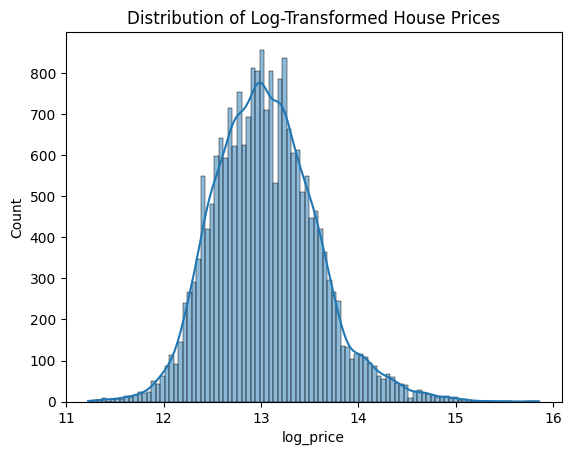

In [ ]:
# Log-price distribution
plt.figure(figsize=(12, 7))
sns.histplot(df["log_price"], bins=100, kde=True)
plt.title("Distribution of Log-Transformed House Prices")
plt.show()

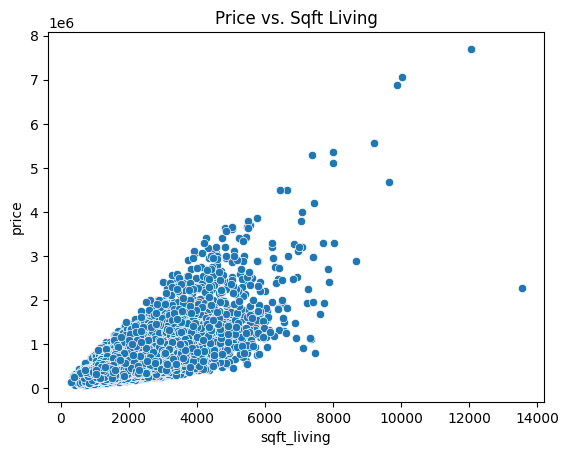

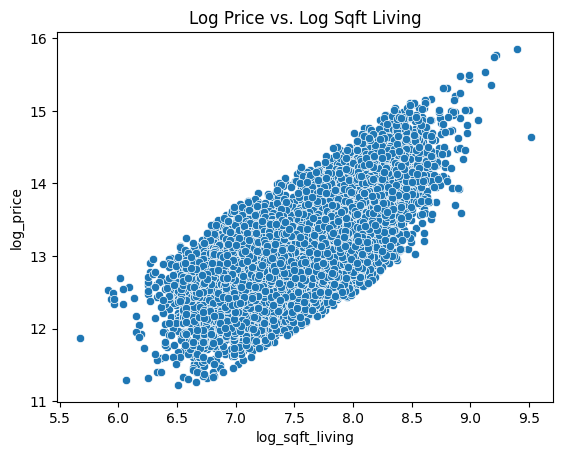

In [ ]:
# Price vs sqft-living & Log-price vs log-sqft-living
plt.figure(figsize=(12, 7))
sns.scatterplot(data=df, x="sqft_living", y="price")
plt.title("Price vs. Sqft Living")
plt.show()

plt.figure(figsize=(12, 7))
sns.scatterplot(data=df, x="log_sqft_living", y="log_price")
plt.title("Log Price vs. Log Sqft Living")
plt.show()

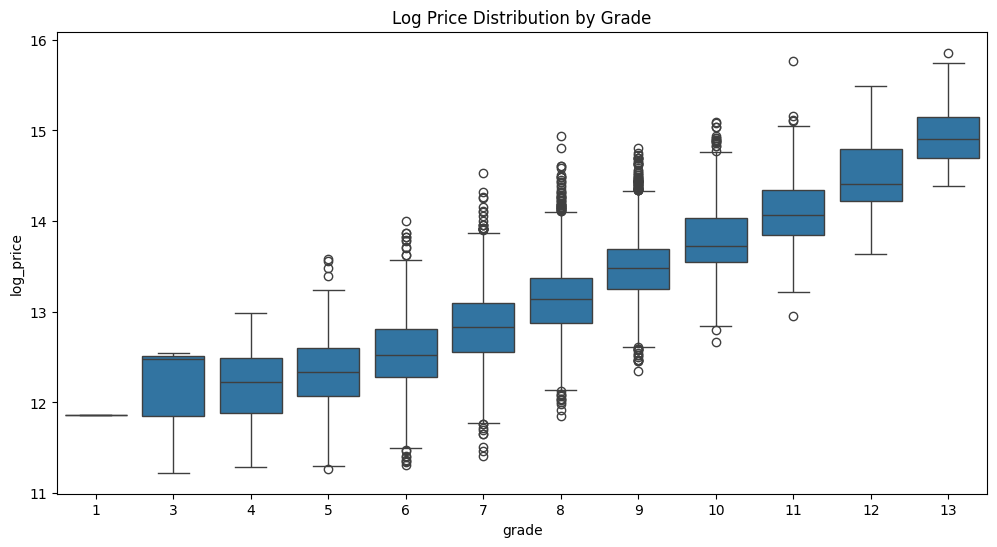

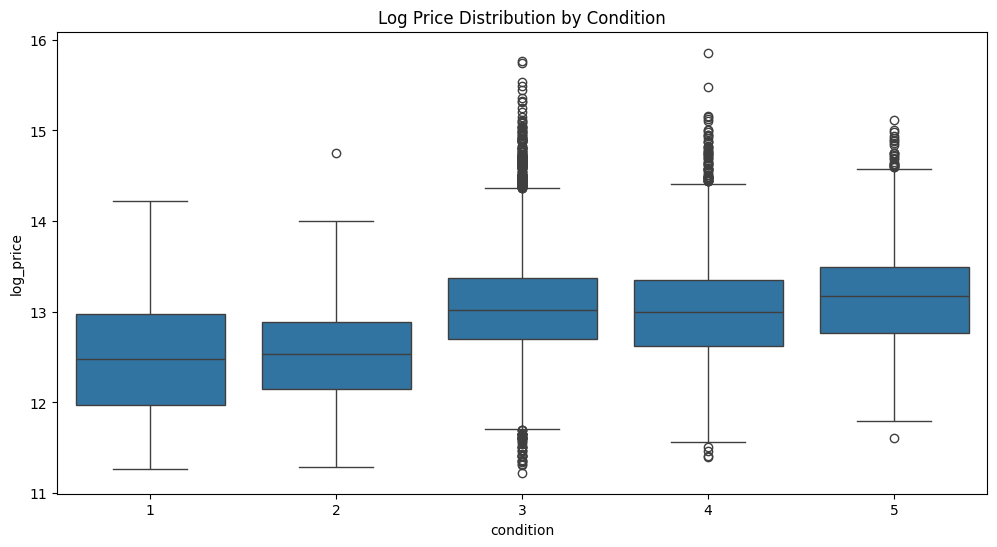

In [ ]:
# --- Other cool graphs

plt.figure(figsize=(12, 7))
sns.boxplot(data=df, x="grade", y="log_price")
plt.title("Log Price Distribution by Grade")
plt.show()

plt.figure(figsize=(12, 7))
sns.boxplot(data=df, x="condition", y="log_price")
plt.title("Log Price Distribution by Condition")
plt.show()

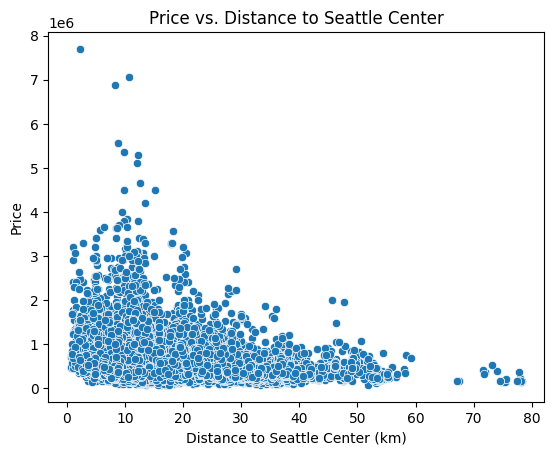

In [ ]:
# --- Price vs dist_to_center

plt.figure(figsize=(12, 7))
sns.scatterplot(data=df, x="dist_to_center", y="price")
plt.title("Price vs. Distance to Seattle Center")
plt.xlabel("Distance to Seattle Center (km)")
plt.ylabel("Price")
plt.show()

# Preparation to ML

In [ ]:
# --- Declaration of our dependent variable (y) and remove the non-log variable (for simplicity)

y = df["log_price"]
X = df.drop(columns=[
    "price", "log_price", "sqft_living", "sqft_lot", "sqft_above", "sqft_basement",
    "sqft_living15", "sqft_lot15", "ratio_living_size15", "ratio_lot_size15",
    "living_lot_ratio", "volume"
])

In [ ]:
# --- Train & Test. The test has 30% of the whole data

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((15129, 50), (6484, 50), (15129,), (6484,))

In [ ]:
X_train.T

167        12412      7691       12460  \
bedrooms                         4          4          4          2   
bathrooms                      2.5       1.75       2.25       1.75   
floors                         2.0        1.0        2.0        2.0   
waterfront                       0          0          0          0   
view                             0          0          0          2   
condition                        3          5          3          3   
grade                            9          7          8          9   
yr_built                      1999       1924       1978       2005   
yr_renovated                     0          0          0          0   
zipcode                      98006      98115      98032      98014   
lat                         47.565    47.6746    47.3742    47.6359   
long                      -122.125    -122.32   -122.284    -121.94   
sale_year                     2015       2014       2014       2014   
sale_month                       3         10          8          6   
days_since_start               326        152        102         52   
age                             16         91         37         10   
season                      Spring       Fall     Summer     Summer   
dist_to_center           18.011644   6.431371  27.847846  30.818184   
dist_to_medina            9.894277     9.1381  27.760192  21.617946   
dist_to_kirkland         14.144685   9.922679  35.279505  19.377763   
dist_to_bellevue          7.594141  11.441661  26.997709  19.741643   
dist_to_redmond          12.121747  14.861384   35.49756  14.239777   
dist_to_issaquah           7.94581  26.878013  25.647527  13.662024   
dist_to_renton            11.45293  22.673492  13.091715   26.86523   
dist_to_kent             22.442647  33.557704   3.535855  36.349074   
dist_to_seatac           18.734668  26.392045   7.123199  34.212277   
dbscan_cluster                   0          0          0          0   
gmm_prob_1                     0.0   0.921172        0.0        0.0   
gmm_prob_2                     0.0        0.0   0.699301        0.0   
gmm_prob_3                 0.89067   0.000395   0.000001   0.002137   
gmm_prob_4                0.000104   0.001237        0.0   0.000068   
gmm_prob_5                     0.0        0.0        0.0        0.0   
gmm_prob_6                0.001041   0.000001     0.0899        0.0   
gmm_prob_7                     0.0        0.0        0.0        0.0   
gmm_prob_8                     0.0   0.000672        0.0        0.0   
gmm_prob_9                     0.0        0.0   0.208367        0.0   
gmm_prob_10               0.000003   0.000002        0.0    0.67145   
gmm_prob_11               0.087973        0.0   0.000769        0.0   
gmm_prob_12                    0.0   0.076522        0.0        0.0   
gmm_prob_13               0.011282        0.0   0.001663   0.113429   
log_sqft_living           7.893572   7.757906   7.691657    7.72312   
log_sqft_lot               8.41161   8.533067     9.1072  12.545975   
log_sqft_above            7.893572   7.064759   7.691657   7.544332   
log_sqft_basement              0.0   7.065613        0.0   5.916202   
log_sqft_living15         7.979339   7.146772   7.682482   7.958577   
log_sqft_lot15            8.411833   8.092545   9.035987  12.299299   
log_ratio_living_size15  -0.085767   0.611134   0.009174  -0.235457   
log_ratio_lot_size15     -0.000222   0.440521   0.071213   0.246676   
log_living_lot_ratio     -0.518038   -0.77516  -1.415543  -4.822855   
log_volume                8.586719   7.757906   8.384804   8.416267   

                             9099       6662       21111      3372   \
bedrooms                         4          2          5          2   
bathrooms                     1.75        1.0        3.5        1.0   
floors                         1.0        1.0        2.5        1.0   
waterfront                       0          0          0          0   
view                             0          0       

In [ ]:
# --- Save the data to Google Drive
#joblib.dump(X_train, "/content/drive/My Drive/X_train.joblib")
#joblib.dump(X_test, "/content/drive/My Drive/X_test.joblib")
#joblib.dump(y_train, "/content/drive/My Drive/y_train.joblib")
#joblib.dump(y_test, "/content/drive/My Drive/y_test.joblib")

print("Data saved to Google Drive.")

Data saved to Google Drive.


## Download Data + Preprocessor

In [ ]:
# --- Load the data from Google Drive
X_train = joblib.load("/content/drive/My Drive/X_train.joblib")
X_test = joblib.load("/content/drive/My Drive/X_test.joblib")
y_train = joblib.load("/content/drive/My Drive/y_train.joblib")
y_test = joblib.load("/content/drive/My Drive/y_test.joblib")

print("Data loaded from Google Drive.")

Data loaded from Google Drive.


In [ ]:
# --- Define each feature category

categorical_features_target = ["zipcode"]                                                     # Define the variable "Target Encoding"
categorical_features_onehot = ["season", "dbscan_cluster" ]                                   # Define the variables "One-hot Encoding"

categorical_features = categorical_features_target + categorical_features_onehot              # "Union" of TE and One-hot

numeric_features = [col for col in X_train.columns
                    if col not in categorical_features]                                       # Numeric feature (all the feature that are not "categorical"...)

print(f"{len(numeric_features)} numeric feature")

47 numeric feature


In [ ]:
# --- Preprocessors to be applied:
# 1. standardization (mean=0 & var=1) of the numeric feature
# 2. Target encoding
# 3. One-Hot Encoding

# for ElasticNet (handles multicollinearity) -> linear model
preprocessor_elastic = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_features),
        ("cat_target", ce.TargetEncoder(), categorical_features_target),
        ("cat_onehot", OneHotEncoder(handle_unknown="ignore", drop="first"), categorical_features_onehot)     # drop="first" to avoid multicollinearity in linear model
    ],
    remainder="passthrough"
)

# for RFECV -> non-linear models
preprocessor_rf = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_features),
        ("cat_target", ce.TargetEncoder(), categorical_features_target),
        ("cat_onehot", OneHotEncoder(handle_unknown="ignore"), categorical_features_onehot)
    ],
    remainder="passthrough"
)

# Linear Model (Baseline)
## Feature selection + Linear Regression

In [ ]:
# --- Declaration key for the dictionary

run_key_linear = "LinearRegression_ElasticNetCV"

In [ ]:
# --- Prepare ElasticNet  as the feature selector.
# ElasticNetCV automatically chooses the best alpha AND l1_ratio.

# l1_ratios to test: L1=1 -> L1 penality ||| L1=0 -> L2 penalty
l1_ratios_to_test = [0.1, 0.5, 0.7, 0.9, 0.95, 0.99, 1.0]

elastic_net_cv = ElasticNetCV(l1_ratio=l1_ratios_to_test,
                              cv=5,
                              random_state=42,
                              n_jobs=-1)

In [ ]:
# --- Linear Pipeline:
# 1. apply the preprocessor_elastic to the data
# 2. perform feature selection through ElasticNetCV
# 3. train linear regression

pipelineEN = Pipeline([
    ("preprocessor", preprocessor_elastic),
    ("feature_selection", SelectFromModel(estimator=elastic_net_cv,
                                          threshold="median")),                 # select feature is abs value is > than median
    ("regressor", LinearRegression())
])

pipelineEN.named_steps

{'preprocessor': ColumnTransformer(remainder='passthrough',
                   transformers=[('num', StandardScaler(),
                                  ['bedrooms', 'bathrooms', 'floors',
                                   'waterfront', 'view', 'condition', 'grade',
                                   'yr_built', 'yr_renovated', 'lat', 'long',
                                   'sale_year', 'sale_month', 'days_since_start',
                                   'age', 'dist_to_center', 'dist_to_medina',
                                   'dist_to_kirkland', 'dist_to_bellevue',
                                   'dist_to_redmond', 'dist_to_issaquah',
                                   'dist_to_renton', 'dist_to_kent',
                                   'dist_to_seatac', 'gmm_prob_1', 'gmm_prob_2',
                                   'gmm_prob_3', 'gmm_prob_4', 'gmm_prob_5',
                                   'gmm_prob_6', ...]),
                                 ('cat_target', TargetEncoder(

In [ ]:
# --- Training & Storing linear model

if run_key_linear not in model_results:
    print(f"--- Training and evaluating '{run_key_linear}' for the first time ---")

    scores = cross_val_score(
                            pipelineEN, X_train, y_train,                       # Pipeliine and training data
                             cv=5,
                             scoring="neg_mean_absolute_error",
                             n_jobs=-1)

    print(f"\nCross-validation MAE: {-scores.mean():.4f}")
    print("Fitting the final model on the full training data...")

    # Training
    pipelineEN.fit(X_train, y_train)

    fitted_elastic_net = pipelineEN.named_steps["feature_selection"].estimator_
    linear_params = {'alpha': fitted_elastic_net.alpha_, 'l1_ratio': fitted_elastic_net.l1_ratio_}

    # Parameter saving
    model_results[run_key_linear] = {
        "best_score": scores.mean(),
        "best_params": linear_params,
        "best_estimator": pipelineEN,
        "cv_results_df": None
        }

    joblib.dump(model_results, model_results_path)
    print(f"'{run_key_linear}' trained & saved.")

else:
    print(f"\n'{run_key_linear}' already trained")



'LinearRegression_ElasticNetCV' already trained


In [ ]:
# --- Chosen l1 & alpha

# load dictionary
linear_result_dict = model_results[run_key_linear]

# Get the FITTED pipeline from the dictionary
fitted_pipeline = linear_result_dict['best_estimator']

# Esimator of elasticnet
fitted_elastic_net = fitted_pipeline.named_steps["feature_selection"].estimator_

ElsaticL1 = fitted_elastic_net.l1_ratio_
ElsaticAlpha = fitted_elastic_net.alpha_

print("Chosen alpha:", ElsaticAlpha)
print("Chosen L1 Ratio:", ElsaticL1)

Chosen alpha: 0.00036930710395064294
Chosen L1 Ratio: 1.0


ElasticNetCV determined through cv that the best possible model was the one with l1_ratio=1.0. This means that a pure Lasso penalty was better than any mix of L1 and L2 penalties.


In [ ]:
# --- All coefficients from ElasticNetCV

# Coefficient values
elsatic_coef = fitted_pipeline.named_steps['feature_selection'].estimator_

# Feature names
feature_names = fitted_pipeline.named_steps['preprocessor'].get_feature_names_out()   # feature name AFTER preprocessor

# Put them together with a series
feature_coef = pd.Series(elsatic_coef.coef_, index=feature_names)

# Sort by absolute value to see the most impactful features
print("Coefficients sorted by absolute value:")
print(feature_coef.abs().sort_values(ascending=False))

Coefficients sorted by absolute value:
cat_target__zipcode             0.357242
num__dist_to_medina             0.240891
num__dist_to_renton             0.197847
num__dist_to_center             0.195783
num__lat                        0.157985
num__dist_to_redmond            0.114272
num__grade                      0.106157
num__log_sqft_above             0.089995
num__long                       0.069982
num__log_sqft_living            0.054116
num__log_volume                 0.051539
num__view                       0.047897
num__log_sqft_lot               0.046955
num__log_sqft_living15          0.046522
num__waterfront                 0.040197
num__floors                     0.038983
num__dist_to_issaquah           0.037166
num__condition                  0.034575
num__bathrooms                  0.032787
num__gmm_prob_1                 0.030435
cat_onehot__dbscan_cluster_2    0.025589
num__days_since_start           0.020667
cat_onehot__season_Spring       0.020155
cat_onehot__season

In [ ]:
# --- Feature selected by ElasticNetCV

mask = fitted_pipeline.named_steps["feature_selection"].get_support()           # get_support() -> boolean arrey (True feature selected, Flase otherwise)

selected_cols = np.array(feature_names)[mask]                                   # Filter feature by the boolean mask

print("Selected features:", selected_cols)

Selected features: ['num__bedrooms' 'num__bathrooms' 'num__floors' 'num__waterfront'
 'num__view' 'num__condition' 'num__grade' 'num__lat' 'num__long'
 'num__days_since_start' 'num__dist_to_center' 'num__dist_to_medina'
 'num__dist_to_redmond' 'num__dist_to_issaquah' 'num__dist_to_renton'
 'num__gmm_prob_1' 'num__gmm_prob_5' 'num__log_sqft_living'
 'num__log_sqft_lot' 'num__log_sqft_above' 'num__log_sqft_basement'
 'num__log_sqft_living15' 'num__log_volume' 'cat_target__zipcode'
 'cat_onehot__season_Spring' 'cat_onehot__season_Summer'
 'cat_onehot__season_Winter' 'cat_onehot__dbscan_cluster_2']


In [ ]:
# --- Linear Regression coefficients

# Linear regression coeff
final_regressor = fitted_pipeline.named_steps['regressor'].coef_

# Series: chosen feature + coeff
results_series = pd.Series(final_regressor, index = selected_cols)

print("--- Linear Regression Model: ---")
print(results_series.sort_values(ascending=False))

--- Linear Regression Model: ---
cat_target__zipcode             0.370366
num__dist_to_renton             0.180564
num__log_volume                 0.135319
num__dist_to_redmond            0.115940
num__grade                      0.102665
num__log_sqft_above             0.092415
num__long                       0.080670
cat_onehot__dbscan_cluster_2    0.078957
num__log_sqft_lot               0.056011
num__view                       0.048761
num__log_sqft_living15          0.043508
num__waterfront                 0.041331
num__gmm_prob_1                 0.039430
num__bathrooms                  0.034843
num__condition                  0.033666
cat_onehot__season_Spring       0.028952
num__days_since_start           0.026408
cat_onehot__season_Summer       0.023525
num__gmm_prob_5                 0.020629
num__log_sqft_basement          0.012792
num__log_sqft_living           -0.000219
cat_onehot__season_Winter      -0.011459
num__bedrooms                  -0.014380
num__dist_to_issaquah   

# Non - Linear models
In this section RFECV feature selection will be apply through a random forest. The features that will be selected by this procedure will be used to train non-linear models:


*   Random Forest
*   HistGradientBoosting
*   XGBoost
*   LightGBM
*   NNMLP
*   Stacking model



## Wrap feature selection (FS) with random forest

In [ ]:
# --- CV that will be used throughout FS

cv_splitter = KFold(n_splits=5,
                    shuffle=True,
                    random_state=42)

In [ ]:
# --- RFECV selector -> iteratively removes features and evaluates model performance using cv

rfecv = RFECV(
    estimator = RandomForestRegressor(                                # Random Forest will be used as estimator
                                      n_estimators=50,                # number of RF trees
                                      random_state=42,
                                      n_jobs=-1),
    cv = cv_splitter,                                                 # CV defined before
    scoring = "neg_mean_absolute_error",                              # max negative MAE = min MAE
    verbose = 1,
    step = 1,                                                         # number of feature removed each time
    min_features_to_select = 5,                                       # min number of feature rfecv will retain
    importance_getter="auto",                                         # "auto" -> feature importance for tree-based models
    n_jobs = -1
)

In [ ]:
# --- Feature selection pipeline:
# 1. apply preprocessor_rf to data
# 2. perform feature selection through rfecv

pipelineRFE = Pipeline([
    ("preprocessor", preprocessor_rf),
    ("feature_selector", rfecv)
])

pipelineRFE.named_steps

{'preprocessor': ColumnTransformer(remainder='passthrough',
                   transformers=[('num', StandardScaler(),
                                  ['bedrooms', 'bathrooms', 'floors',
                                   'waterfront', 'view', 'condition', 'grade',
                                   'yr_built', 'yr_renovated', 'lat', 'long',
                                   'sale_year', 'sale_month', 'days_since_start',
                                   'age', 'dist_to_center', 'dist_to_medina',
                                   'dist_to_kirkland', 'dist_to_bellevue',
                                   'dist_to_redmond', 'dist_to_issaquah',
                                   'dist_to_renton', 'dist_to_kent',
                                   'dist_to_seatac', 'gmm_prob_1', 'gmm_prob_2',
                                   'gmm_prob_3', 'gmm_prob_4', 'gmm_prob_5',
                                   'gmm_prob_6', ...]),
                                 ('cat_target', TargetEncoder(

In [ ]:
# --- RFECV training

pipelineRFE.fit(X_train, y_train)

Fitting estimator with 57 features.
Fitting estimator with 56 features.
Fitting estimator with 55 features.
Fitting estimator with 54 features.
Fitting estimator with 53 features.


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  ['bedrooms', 'bathrooms',
                                                   'floors', 'waterfront',
                                                   'view', 'condition', 'grade',
                                                   'yr_built', 'yr_renovated',
                                                   'lat', 'long', 'sale_year',
                                                   'sale_month',
                                                   'days_since_start', 'age',
                                                   'dist_to_center',
                                                   'dist_to_medina',
                                                   'dist_to_kirkland',
                                                   'dist_to_bellevue',
                                                   'dis...
                                                 ('cat_target', TargetEncoder(),
                                                  ['zipcode']),
                                                 ('cat_onehot',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['season',
                                                   'dbscan_cluster'])])),
                ('feature_selector',
                 RFECV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
                       estimator=RandomForestRegressor(n_estimators=50,
                                                       n_jobs=-1,
                                                       random_state=42),
                       min_features_to_select=5, n_jobs=-1,
                       scoring='neg_mean_absolute_error', verbose=1))])

In [ ]:
# --- Save pipeline

joblib.dump(pipelineRFE, "/content/drive/My Drive/pipelineRFE.joblib")
print("pipelineRFE.joblib saved successfully.")

pipelineRFE.joblib saved successfully.


In [ ]:
# --- Key variables

selector = pipelineRFE.named_steps['feature_selector']
all_feature_names = pipelineRFE.named_steps['preprocessor'].get_feature_names_out()

In [ ]:
# --- Get the final trained estimator and its importances

final_rf_model = selector.estimator_

# Get the names of ONLY the selected features
selected_features_mask = selector.support_                                      # names of ONLY the selected features (boolean)
selected_feature_names = np.array(all_feature_names)[selected_features_mask]    # selected features

importances = final_rf_model.feature_importances_                               # importance scores from the final model

final_importance_df = pd.DataFrame({                                            # Create a DataFrame of the final model importance
    'Feature': selected_feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

optimal_n_features_rfecv = selector.n_features_                                 # Optimal number

print(f"Optimal number of features (RFECV): {optimal_n_features_rfecv}")
print("\n\n--- Feature Importances of the FINAL Model ---")
print("(Based only on the selected features)")
print(final_importance_df.to_string())

Optimal number of features (RFECV): 52


--- Feature Importances of the FINAL Model ---
(Based only on the selected features)
                         Feature  Importance
47           cat_target__zipcode    0.429022
37          num__log_sqft_living    0.243420
6                     num__grade    0.103564
15           num__dist_to_center    0.033944
41        num__log_sqft_living15    0.015252
25               num__gmm_prob_2    0.013351
4                      num__view    0.010712
39           num__log_sqft_above    0.009213
38             num__log_sqft_lot    0.007266
9                       num__lat    0.007069
16           num__dist_to_medina    0.006603
22             num__dist_to_kent    0.006511
46               num__log_volume    0.006349
13         num__days_since_start    0.006161
42           num__log_sqft_lot15    0.006037
7                  num__yr_built    0.005618
23           num__dist_to_seatac    0.005424
10                     num__long    0.005291
3                nu

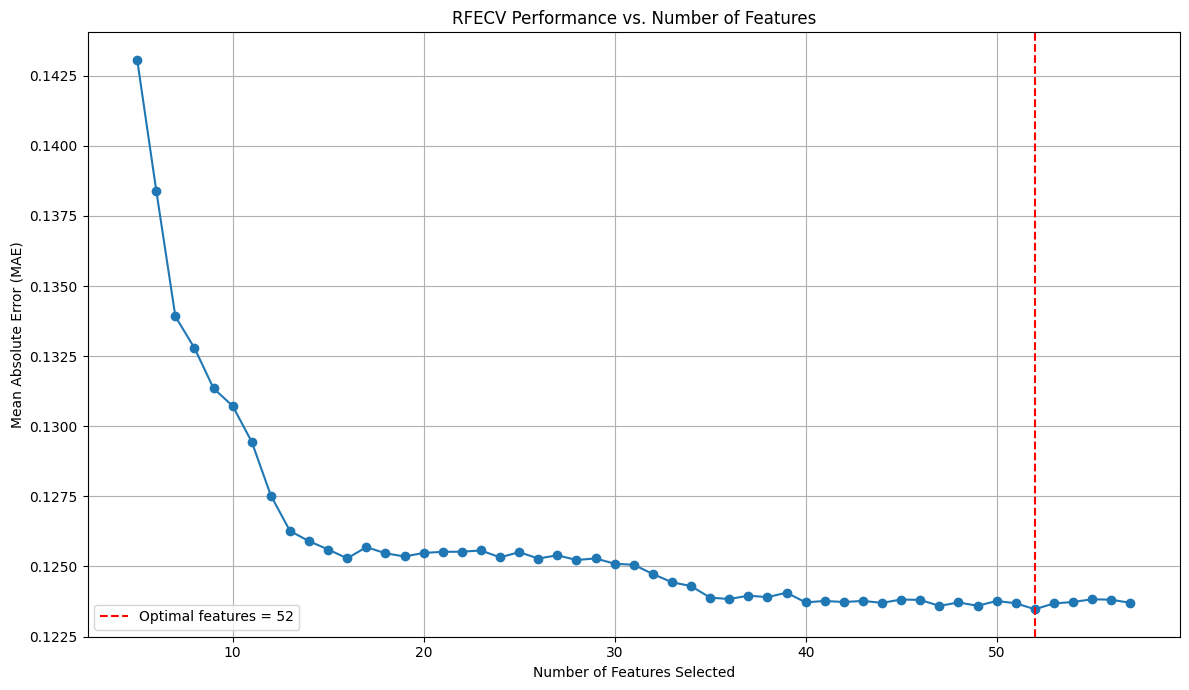

In [ ]:
# --- plot

n_scores = len(rfecv.cv_results_['mean_test_score'])
features_range = range(rfecv.min_features_to_select, rfecv.min_features_to_select + n_scores)

plt.figure(figsize=(12, 7))
plt.plot(features_range, -rfecv.cv_results_['mean_test_score'], marker='o')

# Add red line
plt.axvline(x=optimal_n_features_rfecv, color='red', linestyle='--', label=f'Optimal features = {optimal_n_features_rfecv}')

# Add labels and title
plt.xlabel("Number of Features Selected")
plt.ylabel("Mean Absolute Error (MAE)")
plt.title("RFECV Performance vs. Number of Features")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### One Standard-Error Rule
Select a simpler model that performs statistically as well as the "best" model found by RFECV. This approach is based on the principle of parsimony (or Occam's Razor): if multiple models have comparable performance, we should prefer the simplest one. A simpler model is often more robust, faster, and less likely to be overfit to the training data.

The process is as follows:




1.   Find the best score achieved during cross-validation.
2.   Calculate the standard error at that point.
3.   Set a performance threshold: Best Score - 1 Standard Error.
4.   Select the model with the fewest features that still has a score under/above this threshold.






In [ ]:
# --- "One Standard Error Rule" for parsimonious FS

mean_scores = selector.cv_results_["mean_test_score"]                                         # Extract mean cv scores for each number of features
std_errs = selector.cv_results_["std_test_score"] / np.sqrt(selector.cv.get_n_splits())       # Standard error of the mean score
best_idx = np.argmax(mean_scores)                                                             # Index of the best mean cv score
best_score = mean_scores[best_idx]                                                            # Best mean cv score

one_se_threshold = mean_scores[best_idx] - std_errs[best_idx]                                 # "one standard error" threshold -> the best score minus one standard error

In [ ]:
# --- Find "One-se-error" number of features

# This identifies the most parsimonious model that is still within one standard error of the best
parsimonious_idx = np.where(mean_scores >= one_se_threshold)[0][0]
parsimonious_n_features = parsimonious_idx + selector.min_features_to_select                  # index + the minimum number of features (5)

In [ ]:
# --- Results of FS

print(f"Optimal number of features found by RFECV: {optimal_n_features_rfecv}")
print(f"Best cv score (MAE): {-best_score:.4f}\n")
print("\n--- Applying the 'One Standard Error' Rule ---")
print(f"Threshold (Best Score - 1 SE): {-one_se_threshold:.4f}")
print(f"The most parsimonious model with a statistically comparable score has {parsimonious_n_features} features.")

Optimal number of features found by RFECV: 52
Best cv score (MAE): 0.1235


--- Applying the 'One Standard Error' Rule ---
Threshold (Best Score - 1 SE): 0.1244
The most parsimonious model with a statistically comparable score has 34 features.


In [ ]:
# --- List of parsimonious features

parsimonious_features = final_importance_df['Feature'].head(parsimonious_n_features).to_numpy()
print(f"\nSelected the {len(parsimonious_features)} most important parsimonious features:")
print(final_importance_df.head(parsimonious_n_features))


Selected the 34 most important parsimonious features:
                         Feature  Importance
47           cat_target__zipcode    0.429022
37          num__log_sqft_living    0.243420
6                     num__grade    0.103564
15           num__dist_to_center    0.033944
41        num__log_sqft_living15    0.015252
25               num__gmm_prob_2    0.013351
4                      num__view    0.010712
39           num__log_sqft_above    0.009213
38             num__log_sqft_lot    0.007266
9                       num__lat    0.007069
16           num__dist_to_medina    0.006603
22             num__dist_to_kent    0.006511
46               num__log_volume    0.006349
13         num__days_since_start    0.006161
42           num__log_sqft_lot15    0.006037
7                  num__yr_built    0.005618
23           num__dist_to_seatac    0.005424
10                     num__long    0.005291
3                num__waterfront    0.005103
44     num__log_ratio_lot_size15    0.005082


In [ ]:
# --- Save parimonious feature

joblib.dump(parsimonious_features, "/content/drive/My Drive/parsimonious_features.joblib")
print("parsimonious_features.joblib saved successfully.")

parsimonious_features.joblib saved successfully.


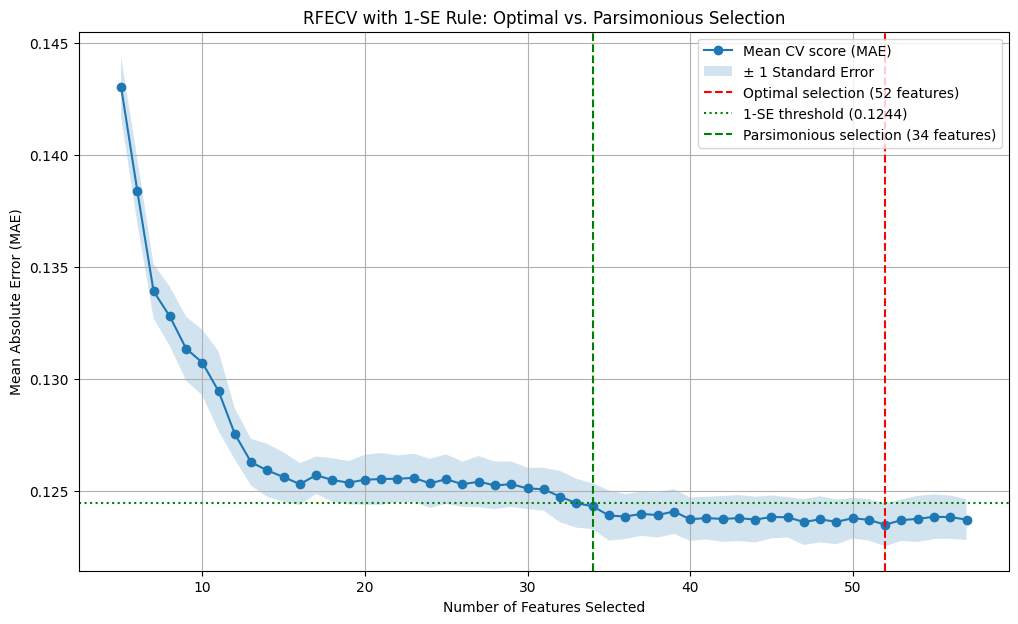

In [ ]:
# --- Plot the results
plt.figure(figsize=(12, 7))
plt.plot(features_range, -mean_scores, marker="o", label="Mean CV score (MAE)")

# Plot the 1-SE band around the best score
plt.fill_between(features_range, -(mean_scores - std_errs), -(mean_scores + std_errs), alpha=0.2, label="± 1 Standard Error")

# Plot the lines for different feature counts
plt.axvline(x = optimal_n_features_rfecv, color="red", linestyle="--", label=f"Optimal selection ({optimal_n_features_rfecv} features)")
plt.axhline(y = -one_se_threshold, color="green", linestyle=":", label=f"1-SE threshold ({-one_se_threshold:.4f})")
plt.axvline(x = parsimonious_n_features , color="green", linestyle="--", label=f"Parsimonious selection ({parsimonious_n_features } features)")

# Add labels and title for clarity
plt.xlabel("Number of Features Selected")
plt.ylabel("Mean Absolute Error (MAE)")
plt.title("RFECV with 1-SE Rule: Optimal vs. Parsimonious Selection")
plt.legend(loc="upper right")
plt.grid(True)
plt.show()

From this plot we can see the with the RED line the optimal feature number selected by RFECV. The green line parallel to the x-axis is the 1 se rule threshold. As we can see from the verical green line parallel to the y-axis, the model with the fewest features that has a score below the threshold is the model with 34 features.

### Preparing data for non-linear training
We are going to use the trained preprocessor from the pipeline to transform both the training and test datasets. We will then selects only the features identified by the "One Standard Error Rule".

In [ ]:
# --- Extract & apply THE FITTED preprocessor to data

preprocessor_rf = pipelineRFE.named_steps["preprocessor"]                       # Extract

X_train_processed = preprocessor_rf.transform(X_train)                          # Apply to training data
X_test_processed = preprocessor_rf.transform(X_test)                            # Apply to test data

In [ ]:
# --- From NumPy arrays to DataFrame for easier FS

X_train_processed_df = pd.DataFrame(X_train_processed, columns=all_feature_names, index=X_train.index)
X_test_processed_df = pd.DataFrame(X_test_processed, columns=all_feature_names, index=X_test.index)

In [ ]:
# --- Filter train and test to keep ONLY the selected parsimonious features

X_train_selected = X_train_processed_df[parsimonious_features]
X_test_selected = X_test_processed_df[parsimonious_features]

print("\nShape of the final training data for model tuning:", X_train_selected.shape)
print("Shape of the final test data for evaluation:", X_test_selected.shape)


Shape of the final training data for model tuning: (15129, 34)
Shape of the final test data for evaluation: (6484, 34)


In [ ]:
X_train_selected.T

167        12412      7691       12460  \
cat_target__zipcode           13.584395  13.281806  12.387133  12.902836   
num__log_sqft_living           0.814845   0.495459   0.339493   0.413565   
num__grade                     1.147615  -0.556657   0.295479   1.147615   
num__dist_to_center           -0.105876  -1.130742   0.764638   1.027516   
num__log_sqft_living15         1.348564  -1.190577   0.443219   1.285244   
num__gmm_prob_2               -0.326914  -0.326914   2.281090  -0.326914   
num__view                     -0.304826  -0.304826  -0.304826   2.326682   
num__log_sqft_above            1.169843  -0.770394   0.697163   0.352278   
num__log_sqft_lot             -0.631735  -0.497689   0.135954   3.931167   
num__lat                       0.031818   0.822812  -1.345204   0.543510   
num__dist_to_medina           -0.770124  -0.848448   1.080409   0.444202   
num__dist_to_kent             -0.228910   0.732290  -1.863919   0.973680   
num__log_volume                1.071708  -0.202664   0.761246   0.809623   
num__days_since_start          1.292658  -0.247911  -0.690603  -1.133296   
num__log_sqft_lot15           -0.667617  -1.058057   0.095629   4.086164   
num__yr_built                  0.946857  -1.607372   0.231673   1.151195   
num__dist_to_seatac           -0.307451   0.483978  -1.507556   1.292240   
num__long                      0.637889  -0.755823  -0.498523   1.960128   
num__waterfront               -0.084397  -0.084397  -0.084397  -0.084397   
num__log_ratio_lot_size15     -0.074393   1.165180   0.126515   0.619998   
num__age                      -0.884829   1.722397  -0.154806  -1.093407   
num__log_living_lot_ratio      1.059173   0.762680   0.024240  -3.904812   
num__log_ratio_living_size15  -0.337077   2.108288  -0.003936  -0.862326   
num__dist_to_issaquah         -1.690511   0.611774   0.462139  -0.995381   
num__gmm_prob_3                3.306114  -0.392079  -0.393718  -0.384845   
num__dist_to_bellevue         -1.070673  -0.644298   1.079595   0.275491   
num__condition                -0.625889   2.444997  -0.625889  -0.625889   
num__dist_to_renton           -0.887734   0.466198  -0.689990   0.971995   
num__dist_to_redmond          -0.785433  -0.537443   1.330532  -0.593710   
num__gmm_prob_1               -0.456062   2.216714  -0.456062  -0.456062   
num__bathrooms                 0.506735  -0.472371   0.180367  -0.472371   
num__gmm_prob_13              -0.167672  -0.230955  -0.221628   0.405280   
num__sale_month               -1.151510   1.100495   0.457065  -0.186365   
num__gmm_prob_6               -0.300268  -0.305589   0.154178  -0.305593   

                                  9099       6662       21111      3372   \
cat_target__zipcode           13.338066  12.507909  12.849290  13.281806   
num__log_sqft_living           0.251885  -2.413912   0.884092  -0.906497   
num__grade                     0.295479  -2.260929   0.295479  -0.556657   
num__dist_to_center            0.482200  -0.028582  -0.046423  -1.017775   
num__log_sqft_living15         0.357705  -1.072810   0.982817  -0.410812   
num__gmm_prob_2               -0.326914  -0.325686  -0.326914  -0.326914   
num__view                     -0.304826  -0.304826  -0.304826  -0.304826   
num__log_sqft_above            0.610046  -2.040766   1.238700  -0.541824   
num__log_sqft_lot              3.869592   0.088451  -0.799372  -0.595301   
num__lat                       0.695791  -0.755567  -0.401929   0.917355   
num__dist_to_medina           -0.176085   0.164766  -0.385558  -0.716926   
num__dist_to_kent              0.843855  -1.348852  -0.873227   0.862087   
num__log_volume               -0.361747  -2.102834   1.460037  -1.118310   
num__days_since_start         -1.106734   0.185927  -0.726019  -1.009342   
num__log_sqft_lot15            3.247718   0.642767  -0.644201  -0.842608   
num__yr_built                  0.265729  -0.687849   1.423646  -2.220387   
num__dist_to_seatac            0.995448  -2.039950  -1.041606   0.637460   
num__

In [ ]:
# --- Save the processed data to Google Drive

#joblib.dump(X_train_selected, "/content/drive/My Drive/X_train_selected.joblib")
#joblib.dump(X_test_selected, "/content/drive/My Drive/X_test_selected.joblib")

#print("Data saved to Google Drive.")

Data saved to Google Drive.


### Load process Non-Linear train & test

In [ ]:
# --- Load the processed data from Google Drive

X_train_selected = joblib.load("/content/drive/My Drive/X_train_selected.joblib")
X_test_selected = joblib.load("/content/drive/My Drive/X_test_selected.joblib")

print("Data loaded from Google Drive.")

Data loaded from Google Drive.


## Model Training

Before tuning our models, it's important to clarify my methodology. I will use the single, optimized set of features selected by RFECV as the input for all subsequent models (Random Forest, HistGradientBoosting, etc.).

One could argue that each model should undergo its own feature selection, as different algorithms might prefer different features. However, approach is a done for several key reasons:



*   Computational Practicality: Nesting feature selection within the hyperparameter tuning loop for every model is computationally prohibitive;
*   Stability: A fully nested procedure can "overfit" the selection process;
*   Simplicity: This two-step process is easier to manage and understand.

### Tuning control switch:
The underlying idea is that performing precise parameter tuning right from the start and hoping to achieve a good result with a limited number of iterations is very difficult. To overcome this problem, a random searche is initially performed to explore the spaces that can lead to better results. Once these are found, a more thorough search is performed within them to achieve a better result.

In [ ]:
# ================================================================= #
#                   TUNING CONTROL SWITCH
# ================================================================= #

# "RANDOM" -> optuna random search ||| "OPTUNA" -> optuna type search

TUNING_STAGE = "OPTUNA"
print(f"--- RUNNING TUNING STAGE: {TUNING_STAGE} ---")

# ================================================================= #

--- RUNNING TUNING STAGE: OPTUNA ---


In [ ]:
# --- CV that will be used throughout model tuning

cv_splitter_tuning = KFold(n_splits=5,
                           shuffle=True,
                           random_state=42)

In [ ]:
# --- Parameter space for Non-Linear Models
# With Optuna search log=True/False -> False (Uniform Distribution): every interval of the same width is equally likely
#                                      True (Log-Uniform Distribution): every multiplicative interval is equally likely. Ideal when with parameters that cover several orders of magnitude

# IF you notice that some parameter are "#" its because I wanted to know that they exist

models_config = {
    "RandomForest": {
        "model": RandomForestRegressor(random_state=42, n_jobs=-1),
        "random_space": {
            "model__n_estimators":          od.IntDistribution(100, 2000),                      # Number of trees in the forest
            "model__max_depth":             od.IntDistribution(10, 80),                         # Max deph of each individual tree (deeper trees are prone to overfit)
            "model__min_samples_split":     od.IntDistribution(2, 50),                          # Min data required in a node for splitting (higher valeus -> act as regularizer)
            "model__min_samples_leaf":      od.IntDistribution(1, 20),                          # Min data tha must be present in a leaf node
            "model__max_features":          od.CategoricalDistribution(["sqrt",                 # number of feature to consider when looking for the best split
                                                                        "log2"]),
        },
        "optuna_space": {
            "model__n_estimators":          od.IntDistribution(1000, 2500),
            "model__max_depth":             od.IntDistribution(10, 30),
            "model__min_samples_split":     od.IntDistribution(10, 25),
            "model__min_samples_leaf":      od.IntDistribution(2, 10),
            "model__max_features":          od.CategoricalDistribution(["sqrt"]),
        }
    },
    "HistGradientBoosting": {
        "model": HistGradientBoostingRegressor(
            random_state=42,
            validation_fraction=0.1,
            n_iter_no_change=50
        ),
        "random_space": {
            "model__learning_rate":        od.FloatDistribution(0.01, 0.3, log=True),           # Step-size shrinkage. It scales the contribution of each tree
            "model__max_iter":             od.IntDistribution(100, 2000),                       # The number of boosting stages
            "model__max_leaf_nodes":       od.IntDistribution(20, 100),                         # The maximum number of leaves per tree
            "model__min_samples_leaf":     od.IntDistribution(10, 50),                          # Minimum number of samples required to be at a leaf node
            "model__l2_regularization":    od.FloatDistribution(1e-6, 1.0, log=True),           # The L2 regularization term on weights (help prevent overfit)
            "model__max_depth":            od.IntDistribution(3, 20),                           # Max deph of each tree
        },
        "optuna_space": {
            "model__learning_rate":        od.FloatDistribution(0.01, 0.1, log=True),
            "model__max_iter":             od.IntDistribution(800, 2500),
            "model__max_leaf_nodes":       od.IntDistribution(30, 80),
            "model__min_samples_leaf":     od.IntDistribution(15, 40),
            "model__l2_regularization":    od.FloatDistribution(1e-4, 1.0, log=True),
            "model__max_depth":            od.IntDistribution(8, 218),
        }
    },
    "XGBoost": {
        "model": XGBRegressor(
            random_state=42,
            objective="reg:absoluteerror",                                                       # Training metrics (XGBOOST default is MSE)
            n_jobs=-1
        ),
        "random_space": {
            "model__learning_rate":        od.FloatDistribution(0.01, 0.3, log=True),            # Step-size shrinkage. It scales the contribution of each tree
            "model__n_estimators":         od.IntDistribution(100, 2000),                        # The number of boosting stages
            "model__max_depth":            od.IntDistribution(3, 20),                            # Max deph of each tree
            "model__min_child_weight":     od.IntDistribution(1, 20),                            # Minimum sum of instance weight needed in a child
            "model__subsample":            od.FloatDistribution(0.6, 1.0, log=False),            # Fraction of train data to be used for each tree (prevent overfit)
            "model__colsample_bytree":     od.FloatDistribution(0.6, 1.0, log=False),            # The fraction of features to be used when constructing each tree
            "model__reg_alpha":            od.FloatDistribution(1e-6, 1.0, log=True),            # L1 regularization
            "model__reg_lambda":           od.FloatDistribution(1e-6, 1.0, log=True),            # L2 regularization
        },
        "optuna_space": {
            "model__learning_rate":        od.FloatDistribution(0.01, 0.1, log=True),
            "model__n_estimators":         od.IntDistribution(800, 2500),
            "model__max_depth":            od.IntDistribution(3, 8),
            "model__min_child_weight":     od.IntDistribution(10, 30),
            "model__subsample":            od.FloatDistribution(0.6, 1.0, log=False),
            "model__colsample_bytree":     od.FloatDistribution(0.7, 1.0, log=False),
            "model__reg_alpha":            od.FloatDistribution(1e-6, 1.0, log=True),
            "model__reg_lambda":           od.FloatDistribution(1e-6, 1.0, log=True),
        },
    },
    "LightGBM": {
        "model": lgb.LGBMRegressor(
            random_state=42,
            verbose=-1,
            n_jobs=-1
        ),
        "random_space": {
            "model__learning_rate":        od.FloatDistribution(0.01, 0.3, log=True),           # Step-size shrinkage. It scales the contribution of each tree
            "model__n_estimators":         od.IntDistribution(100, 2000),                       # The number of boosting stages
            "model__num_leaves":           od.IntDistribution(20, 100),                         # Control complexity of the tree model
            "model__min_child_samples":    od.IntDistribution(10, 50),                          # Minimum num of data needed in a child
            "model__subsample":            od.FloatDistribution(0.6, 1.0, log=False),           # Fraction of train data to be used for each tree (prevent overfit)
            "model__colsample_bytree":     od.FloatDistribution(0.6, 1.0, log=False),           # The fraction of features to be used when constructing each tree
            "model__reg_alpha":            od.FloatDistribution(1e-6, 1.0, log=True),           # L1 regularization
            "model__reg_lambda":           od.FloatDistribution(1e-6, 1.0, log=True),           # L2 regularization
        },
        "optuna_space": {
            "model__learning_rate":        od.FloatDistribution(0.01, 0.2, log=True),
            "model__n_estimators":         od.IntDistribution(100, 1500),
            "model__num_leaves":           od.IntDistribution(20, 80),
            "model__min_child_samples":    od.IntDistribution(10, 50),
            "model__subsample":            od.FloatDistribution(0.6, 1.0, log=False),
            "model__colsample_bytree":     od.FloatDistribution(0.6, 1.0, log=False),
            "model__reg_alpha":            od.FloatDistribution(1e-6, 1.0, log=True),
            "model__reg_lambda":           od.FloatDistribution(1e-6, 1.0, log=True),
        }
    },
    "NNMLP": {
        "model": MLPRegressor(
            random_state=42,
            max_iter=500,                                                                                           # Max epochs
            early_stopping=True                                                                                     # stop mechanism to prevent overfit (default is if after 10 epochs no change -> stop)
        ),
        "random_space": {
            "model__hidden_layer_sizes":   od.CategoricalDistribution([(50, 25),                                    # Number of neurons in each layer: 50 first hidden, 25 second hidden
                                                                       (100, 50),                                   # 100 first hidden, 50 second hidden
                                                                       (150, 75),                                   # 150 first hidden, 75 second hidden
                                                                       (100, 50, 25),                               # 100 first hidden, 50 second hidden, 25 third hidden
                                                                       (150, 100, 50),                              # 150 first hidden, 100 second hidden, 50 third hidden
                                                                       (200, 100, 50, 25),                          # 200 first hidden, 100 second hidden, 50 third hidden, 25 fourth hidden
                                                                       (250, 150, 100, 50),                         # 250 first hidden, 150 second hidden, 100 third hidden, 50 fourth hidden
                                                                       ]),
            "model__alpha":                od.FloatDistribution(1e-5, 1.0, log=True),                               # L2 regularization
            "model__learning_rate_init":   od.FloatDistribution(1e-4, 1e-2, log=True),                              # Learning rate
            "model__activation":           od.CategoricalDistribution(["relu", "tanh"]),                            # Activation function
            "model__solver":               od.CategoricalDistribution(["adam", "sgd"]),                             # Optimizer
            "model__batch_size":           od.CategoricalDistribution([32, 64, 128]),                               # Batch size
        },
        "optuna_space": {
            "model__hidden_layer_sizes":   od.CategoricalDistribution([(100, 50),
                                                                       (150, 75),
                                                                       (150, 100, 50),
                                                                       (200, 100, 50, 25)
                                                                       ]),
            "model__alpha":                od.FloatDistribution(1e-5, 0.1, log=True),
            "model__learning_rate_init":   od.FloatDistribution(1e-4, 2e-3, log=True),
            "model__activation":           od.CategoricalDistribution(["tanh"]),
            "model__solver":               od.CategoricalDistribution(["adam"]),
            "model__batch_size":           od.CategoricalDistribution([64, 128]),
        }
    },
}

/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:518: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 25) which is of type tuple.
  warnings.warn(message)
/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:518: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 50) which is of type tuple.
  warnings.warn(message)
/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:518: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (150, 75) which is of type tuple.
  warnings.warn(message)
/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:518: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage b

In [ ]:
# --- Tuning & Saving Loop
# This training loop uses MLFlow and RANDOM/OPTUNA search (depending on the above swtich)
# The for cycle loop for the models name ("RandomForest") and the keys ("model", "optuna_space", "random_space")
# The first "if" is used to check if a model was already tuned (we dont want to spend time on the same opt...)
# The second "if" is used to select the tuning strategy
# After the selection, MLflow strats
# A "try/except" is used to NOT STOP the loop if there is any errors (we dont want that if only one model doesnt work the whole loop stops)
# Than the MLflow logging callback
# OptunaSearchCV starts
# Training strats
# MLflow log the result
# The results are saved "model_results[run_key] = {}"
# The model_results is updated so the model wont be tuned again "joblib.dump(model_results, model_results_path"
# The last "except" is related to the initial "try"

# Training and Tuning Loop
for name, config in models_config.items():                                                    # "name" -> model's name ("RandomForest",...) ||| "config" -> model & spaces
    run_key = f"{name}_{TUNING_STAGE}"

    # check if the model has already been tuned
    if run_key in model_results:
        print(f"\n--- Model '{run_key}' already tuned. Skipping. ---")
        continue                                                                              # Skip to the next model if already tuned

    # Tuning strategy
    if TUNING_STAGE == "RANDOM":
        current_space = config["random_space"]
        sampler = RandomSampler(seed=42)                                                      # Random search
        n_trials = 10                                                                         # A moderate number of trials for exploration
    else:                                                                                     # OPTUNA
        current_space = config["optuna_space"]
        sampler = None                                                                        # Use Optuna's default (TPE - Bayesian)
        n_trials = 20                                                                         # More intensive search

    # Start MLflow
    with mlflow.start_run(run_name=f"{name}_{TUNING_STAGE}_Tuning") as parent_run:
        print(f"\n--- Tuning {name} (MLflow Run ID: {parent_run.info.run_id}) ---")
        mlflow.log_param("model_name", name)

        # Setup pipeline
        try:
            print(f"\nTuning {name}")
            pipeline = Pipeline([("model", config["model"])])                                 # Pipeline with the model

            # MLflow callback
            def mlflow_callback(study, trial):
                trial_name = f"{name}_trial_{trial.number}"
                with mlflow.start_run(run_name=trial_name, nested=True):
                    mlflow.log_params(trial.params)                                           # Log the hyperparameters that Optuna is testing
                    mlflow.log_metric("cv_mae", -trial.value)                                 # Log the resulting score (MAE)

            # OptunaSearchCV starts
            optuna_search = OptunaSearchCV(
                estimator = pipeline,                                                         # Pipeline with the model
                param_distributions = current_space,                                          # Parameter space
                n_trials = n_trials,                                                          # Numb of iteration
                cv = cv_splitter_tuning,                                                      # CV
                scoring = "neg_mean_absolute_error",                                          # Max negative MAE = min MAE (Eval metric)
                n_jobs = -1,
                random_state = 42,
                verbose = 1,
                callbacks=[mlflow_callback]                                                   # MLflow callback
            )

            optuna_search.fit(X_train_selected, y_train)                                      # TRAIN!!!

            # MLFLOW: After tuning is complete, log the best results to the PARENT run
            mlflow.log_params(optuna_search.best_params_)
            mlflow.log_metric("best_cv_mae", -optuna_search.best_score_)
            mlflow.set_tag("tuning_status", "COMPLETE")

            ## MLFLOW: Log the best model itself as an "artifact"
            mlflow.sklearn.log_model(
                sk_model=optuna_search.best_estimator_,
                artifact_path=name,                                                           # This creates a folder named after the model
                registered_model_name=f"{name}_Best"                                          # Registers the model for easy access
            )


            # Store in "model_results" the essential results of the fitted "OptunaSearchCV" object -> a dictionary of the results
            model_results[run_key] = {
                "best_params": optuna_search.best_params_,
                "best_score": optuna_search.best_score_,
                "best_estimator": optuna_search.best_estimator_,
                "cv_results_df": optuna_search.trials_dataframe()
            }

            print(f"\nBest parameters found for {name}: {optuna_search.best_params_}")
            print(f"Best CV MAE for {name}: {-optuna_search.best_score_:.4f}\n")

            # Save the updated DICTIONARY after each successful run
            joblib.dump(model_results, model_results_path)
            print(f"Successfully trained {name} and updated results file.")

        # If any error for a given model
        except Exception as e:
            print(f"\n!!! An error when tuning {name} !!!")
            print(f"Error: {e}")
            print(f"Skipping to the next model.\n")
            continue

print("\n--- All model tuning attempts are complete. ---")


--- Model 'RandomForest_OPTUNA' already tuned. Skipping. ---

--- Model 'HistGradientBoosting_OPTUNA' already tuned. Skipping. ---

--- Model 'XGBoost_OPTUNA' already tuned. Skipping. ---

--- Model 'LightGBM_OPTUNA' already tuned. Skipping. ---

--- Model 'NNMLP_OPTUNA' already tuned. Skipping. ---

--- All model tuning attempts are complete. ---


In [ ]:
# --- Summary of non-linear training results

model_results = joblib.load(model_results_path)

for name, result in model_results.items():
    # We add conditions to filter out the baseline and the final stacking model
    if "Linear" not in name and "Stacking" not in name:
        print(f"\n--- Results for {name} ---")
        # Access the dictionary keys to get the score and parameters
        print(f"Best CV MAE: {-result['best_score']:.4f}")
        print(f"Best parameters found: {result['best_params']}")


--- Results for RandomForest_RANDOM ---
Best CV MAE: 0.1220
Best parameters found: {'model__n_estimators': 1426, 'model__max_depth': 17, 'model__min_samples_split': 16, 'model__min_samples_leaf': 5, 'model__max_features': 'sqrt'}

--- Results for HistGradientBoosting_RANDOM ---
Best CV MAE: 0.1128
Best parameters found: {'model__learning_rate': 0.01753735789843051, 'model__max_iter': 986, 'model__max_leaf_nodes': 51, 'model__min_samples_leaf': 24, 'model__l2_regularization': 0.07612304938739559, 'model__max_depth': 13}

--- Results for XGBoost_RANDOM ---
Best CV MAE: 0.1096
Best parameters found: {'model__learning_rate': 0.06411740785288085, 'model__n_estimators': 1198, 'model__max_depth': 4, 'model__min_child_weight': 14, 'model__subsample': 0.6729448986474869, 'model__colsample_bytree': 0.8702575477386648, 'model__reg_alpha': 5.254731211258775e-05, 'model__reg_lambda': 2.3967171438256342e-06}

--- Results for LightGBM_RANDOM ---
Best CV MAE: 0.1109
Best parameters found: {'model__le

In [ ]:
# Terminate open tunnels if any
ngrok.kill()

# Set the authtoken (get a free one from https://dashboard.ngrok.com/get-started/your-authtoken)
# Replace "PUT_HERE_YOUR_TOKEN" with your actual token
NGROK_AUTH_TOKEN = "PUT_HERE_YOUR_TOKEN"
ngrok.set_auth_token(NGROK_AUTH_TOKEN)

# Get the MLflow tracking URI. In Colab, this will be a local file path. (THE RESUTS WILL BE DELETED SINCE IT IS IN COLAB)
tracking_uri = mlflow.get_tracking_uri()

# Run the MLflow UI in the background
get_ipython().system_raw(f"mlflow ui --backend-store-uri {tracking_uri} &")

# Open a tunnel to the MLflow UI (default port is 5000)
public_url = ngrok.connect(5000)
print("\n" + "="*80)
print(f"MLflow UI is running! Click the link below:")
print(public_url)
print("="*80)


MLflow UI is running! Click the link below:
NgrokTunnel: "https://ac0cf30a2685.ngrok-free.app" -> "http://localhost:5000"


Random Forest Optuna MLflow example

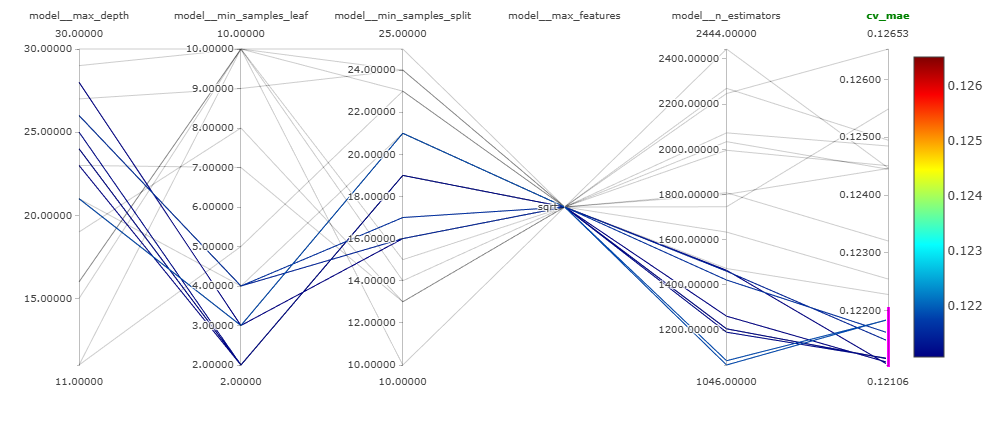

## Stacking Model

Stacking is an ensemble learning technique where multiple different models (called base learners) are trained on the same dataset, and their predictions are then combined by a meta-model to produce the final output.

*   Train several base models independently on the training data
*   Collect their predictions via cross-validation
*   Use these predictions as new features to train a meta-model
*   For new data, each base model makes a prediction -> meta-model combines them into the final prediction.

It’s important to use base learners that make different kinds of errors, so that the meta-model can correct them and improve generalization.

I used Random Forest (bagging) and XGBoost (boosting) as base learners.
Their predictions are combined by Ridge Regression, which learns the optimal weighting while controlling overfitting through regularization.

In [ ]:
# --- Define stacking models for dictionary

stacking_model_name = "Stacking"

In [ ]:
#--- Load result from previous tuning

model_results = joblib.load(model_results_path)
print("Results loaded successfully.")

Results loaded successfully.


In [ ]:
# --- XGB & RF parameters

def find_model_result(model_base_name):
    if f"{model_base_name}_OPTUNA" in model_results:
        return model_results[f"{model_base_name}_OPTUNA"]
    elif f"{model_base_name}_RANDOM" in model_results:
        return model_results[f"{model_base_name}_RANDOM"]

rf_best_params = find_model_result("RandomForest")['best_params']
xgb_best_params = find_model_result("XGBoost")['best_params']

# Remove "model__" prefix
rf_best_params = {key.replace("model__", ""): value for key, value in rf_best_params.items()}
xgb_best_params = {key.replace("model__", ""): value for key, value in xgb_best_params.items()}

print("Optimized parameters:\n")
print("XGB:", xgb_best_params)
print("RF:", rf_best_params)

Optimized parameters:

XGB: {'learning_rate': 0.028553019996015266, 'n_estimators': 2242, 'max_depth': 6, 'min_child_weight': 28, 'subsample': 0.7455688638263398, 'colsample_bytree': 0.8993012004617488, 'reg_alpha': 9.35627623444339e-06, 'reg_lambda': 0.00044617115641429166}
RF: {'n_estimators': 1465, 'max_depth': 28, 'min_samples_split': 16, 'min_samples_leaf': 3, 'max_features': 'sqrt'}


In [ ]:
# --- Define the Stacking Regressor
# I am creating NEW, UN-FITTED models with these best hyperparam

base_estimators = [
    ("rf", RandomForestRegressor(**rf_best_params,
                                 random_state=42,
                                 n_jobs=-1)),
    ("xgb", XGBRegressor(**xgb_best_params,
                         objective="reg:absoluteerror",                         # Training metrics (XGBOOST default is MSE)
                         random_state=42,
                         n_jobs=-1))
]

In [ ]:
# --- The Stacking Regressor with a final Ridge estimator

stacking_reg = StackingRegressor(
    estimators = base_estimators,
    final_estimator = Ridge(),
    n_jobs = -1
)

In [ ]:
# --- Search space parameters for Ridge

stacking_search_space = {
    "final_estimator__alpha": od.FloatDistribution(0.1, 10.0, log=True),        # L2 regularization
    "passthrough":            od.CategoricalDistribution([True,                 # "True"  -> Ridge has in input the predictions of RF and XGB adn the original data
                                                          False]),              # "False" -> Ridge has in input ONLY the predictions of RF and XGB;
}

In [ ]:
# --- Hyperparameter search for the stacking model

optuna_search_stacking = OptunaSearchCV(
    estimator = stacking_reg,
    param_distributions = stacking_search_space,
    n_trials = 5,                                                               # Fewer trials because there are 2 hypeparam (and the computational time is very big...)
    cv = cv_splitter_tuning,
    scoring = "neg_mean_absolute_error",
    n_jobs = -1,
    random_state = 42
)

/tmp/ipython-input-1916600239.py:3: ExperimentalWarning: OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
  optuna_search_stacking = OptunaSearchCV(


In [ ]:
# --- RUN & SAVE STACKING !!!

if stacking_model_name not in model_results:
    print(f"\n--- Tuning '{stacking_model_name}' model ---")
    # Train
    optuna_search_stacking.fit(X_train_selected, y_train)

    # Save results in dictionary format
    model_results[stacking_model_name] = {
        "best_score": optuna_search_stacking.best_score_,
        "best_params": optuna_search_stacking.best_params_,
        "best_estimator": optuna_search_stacking.best_estimator_,
        "cv_results_df": optuna_search_stacking.trials_dataframe()
    }
    joblib.dump(model_results, model_results_path)
    print("Stacking model tuned & saved.")

else:
    print(f"\n--- '{stacking_model_name}' already tuned ---")



--- 'Stacking' already tuned ---


In [ ]:
# --- Results of the stackign model

stacking_result_dict = model_results[stacking_model_name]
print(f"\nBest CV MAE for Stacking: {-stacking_result_dict['best_score']:.4f}")
print(f"Best parameters found: {stacking_result_dict['best_params']}\n")


Best CV MAE for Stacking: 0.1087
Best parameters found: {'final_estimator__alpha': 0.17781133115897188, 'passthrough': True}



# Final model Evaluation on Test set
Now that I have tuned my models, the final and most important step is to evaluate the best version of each model on the held-out test set (X_test, y_test). This gives us an unbiased estimate of their performance on new, unseen data.
Crucially, since our target variable y is log-transformed, we must transform the predictions back using np.exp() to calculate the final Root Mean Squared Error (RMSE) in the original dollar amount.

In [ ]:
# --- Assemble all "Champion" Models for the final evaluation

# Load the final version of the results, which now includes the stacking model
model_results = joblib.load(model_results_path)

# This dictionary will hold the final, ready-to-use model objects.
models_to_evaluate = {}

for name, result_dict in model_results.items():
    if isinstance(result_dict, dict) and 'best_estimator' in result_dict and ("OPTUNA" in name or "Stacking" in name or "ElasticNetCV" in name):
        print(f"Adding '{name}'")
        models_to_evaluate[name] = result_dict['best_estimator']
    else:
        print(f"Skipping '{name}' since it was a random search.")

print("\nFinal set of models ready for evaluation:")
for model_name in models_to_evaluate.keys():
    print(f"- {model_name}")

Skipping 'RandomForest_RANDOM' since it was a random search.
Skipping 'HistGradientBoosting_RANDOM' since it was a random search.
Skipping 'XGBoost_RANDOM' since it was a random search.
Skipping 'LightGBM_RANDOM' since it was a random search.
Skipping 'NNMLP_RANDOM' since it was a random search.
Adding 'LinearRegression_ElasticNetCV'
Adding 'HistGradientBoosting_OPTUNA'
Adding 'XGBoost_OPTUNA'
Adding 'LightGBM_OPTUNA'
Adding 'NNMLP_OPTUNA'
Adding 'RandomForest_OPTUNA'
Adding 'Stacking'

Final set of models ready for evaluation:
- LinearRegression_ElasticNetCV
- HistGradientBoosting_OPTUNA
- XGBoost_OPTUNA
- LightGBM_OPTUNA
- NNMLP_OPTUNA
- RandomForest_OPTUNA
- Stacking


In [ ]:
# --- Setup for Evaluation

final_scores_point = []
y_test_dollars = np.exp(y_test)

y_train_dollars = np.exp(y_train)                                               # WHY THIS? to check if there is overfitting (low mae on train - high error on test)

In [ ]:
# --- Performance metrics

for name, model_pipeline in models_to_evaluate.items():
    print(f"Evaluating: {name}")

    # Select the correct dataset for the model
    if name == "LinearRegression_ElasticNetCV":
        X_train_eval, X_test_eval = X_train, X_test
    else:
        X_train_eval, X_test_eval = X_train_selected, X_test_selected

    # Fit the model on the full training data
    model_pipeline.fit(X_train_eval, y_train)

    # Make predictions (log scale) and convert to dollars
    y_pred_log_test = model_pipeline.predict(X_test_eval)
    y_pred_dollars_test = np.exp(y_pred_log_test)
    y_pred_dollars_train = np.exp(model_pipeline.predict(X_train_eval))

    # Store scores
    final_scores_point.append({
        "Model": name,
        "Test MAE ($)": mean_absolute_error(y_test_dollars, y_pred_dollars_test),
        "Test R²": r2_score(y_test_dollars, y_pred_dollars_test),
        "Test MAPE": mean_absolute_percentage_error(y_test_dollars, y_pred_dollars_test),
        "Train MAE ($)": mean_absolute_error(y_train_dollars, y_pred_dollars_train),
    })

Evaluating: LinearRegression_ElasticNetCV
Evaluating: HistGradientBoosting_OPTUNA
Evaluating: XGBoost_OPTUNA
Evaluating: LightGBM_OPTUNA
Evaluating: NNMLP_OPTUNA
Evaluating: RandomForest_OPTUNA
Evaluating: Stacking


In [ ]:
# --- Final Summary Table

summary_df = pd.DataFrame(final_scores_point).sort_values(by="Test MAE ($)")

# Define column order
column_order = [
    "Model", "Train MAE ($)", "Test MAE ($)",  "Test R²", "Test MAPE"
]
summary_df = summary_df[column_order]

# Set display options for readability
pd.set_option("display.float_format", lambda x: f"{x:,.4f}")

print("\n--- Final Model Comparison ---")
print(summary_df.to_string(index=False))


--- Final Model Comparison ---
                        Model  Train MAE ($)  Test MAE ($)  Test R²  Test MAPE
               XGBoost_OPTUNA    38,275.6276   60,139.6224   0.9115     0.1120
                     Stacking    41,087.4642   60,261.2533   0.9131     0.1113
              LightGBM_OPTUNA    37,319.1848   60,834.0021   0.9157     0.1125
  HistGradientBoosting_OPTUNA    45,217.8093   61,998.5047   0.9125     0.1146
                 NNMLP_OPTUNA    60,961.9455   68,311.5196   0.8817     0.1225
          RandomForest_OPTUNA    48,624.1571   71,608.6455   0.8462     0.1243
LinearRegression_ElasticNetCV    71,308.7863   74,208.2916   0.8768     0.1331


Summary:

*   Best Model: The Stacking model is the narrow winner for point prediction accuracy, with the lowest Test MAE (\$60,261) and the highest Test R² (0.9131). This means it makes the most accurate and reliable price predictions on unseen data.

Detailed analisys:

*   Point Prediction Accuracy: The best-performing models are Stacking, XGBoost, LightGBM, and HistGradientBoosting, all achieving Test MAEs between \$60k - \$62k and Test R² around 0.912 - 0.916. The baseline LinearRegression is notably less accurate, with a Test MAE over $74k. Compared to it, XGBoost reduces the absolute error by about \$14,000 (19%), which justifies the added complexity of tree-based ensembles.

*   Overfitting Analysis: The LinearRegression and NNMLP models show the smallest gap between train and test metrics, suggesting better generalization but lower peak performance. The top models are more complex and achieve higher accuracy but exhibit some overfitting, as seen in their lower Test MAE relative to Train MAE.

*   The MAPE values confirm the MAE ranking. The leading models (Stacking, XGBoost, LightGBM) have Test MAPE values around 11.1% - 11.3%, meaning their predictions deviate by that percentage from the true price on average. The baseline LinearRegression is about 2 percentage points worse in relative error (13.3%).

*   Stacking consideration: even if it isn't the best model for MAE, we can consider a success the model. By combining Random Forst with an high MAE and XGBoost with a low MAE, the predictions on the test are very close to the best model, but it is more stable: there is less difference between train and test MAE and it is able to explain a greater amount of variance

**EVEN IF THE BEST MODEL CAN BE CONSIDERED THE MODEL WITH THE LOWER MAE. ANOTHER ADVANTAGE OF THIS CHOICE IS THE REDUCED COMPUTATIONAL COST**



In [ ]:
# Best model
best_model_name = summary_df.iloc[0]["Model"]
print(f"\nChampion model for diagnostics: '{best_model_name}'")


Champion model for diagnostics: 'XGBoost_OPTUNA'


In [ ]:
# --- xgb save

best_xgb_pipeline = model_results["XGBoost_OPTUNA"]['best_estimator']
joblib.dump(best_xgb_pipeline, 'xgb_model_pipeline.joblib')

['xgb_model_pipeline.joblib']

## Graphical Diagnostic

Mapie will be used to plot and interpreter the confidence interval of the predicition

/usr/local/lib/python3.11/dist-packages/mapie/utils.py:564: UserWarning: WARNING: at least one point of training set belongs to every resamplings.
Increase the number of resamplings
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/mapie/aggregation_functions.py:118: RuntimeWarning: Mean of empty slice
  return np.nanmean(X, axis=1)


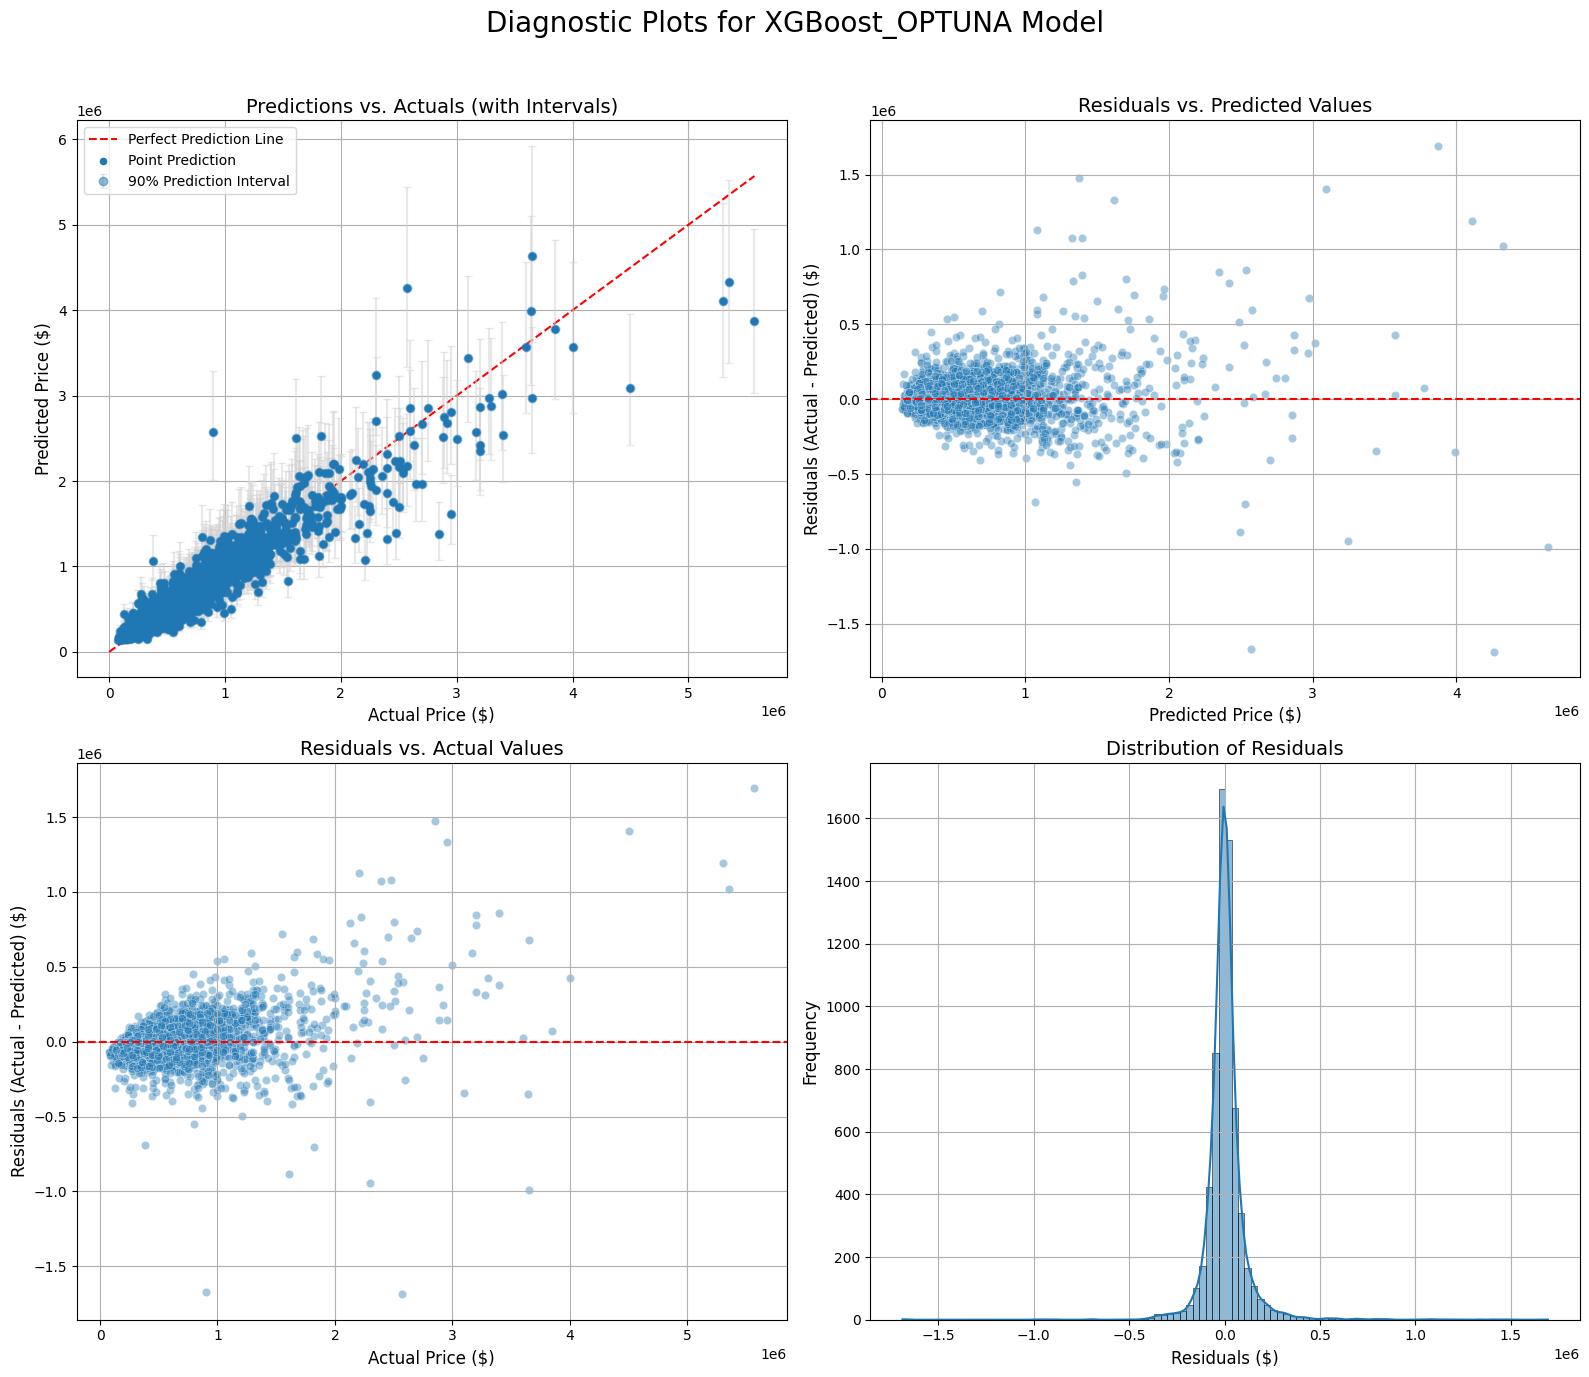

In [ ]:
# --- Setup data for the champion model

best_model_pipeline = models_to_evaluate[best_model_name]
if best_model_name == "LinearRegression_ElasticNetCV":
    X_train_eval, X_test_eval = X_train, X_test
else:
    X_train_eval, X_test_eval = X_train_selected, X_test_selected

# --- Use MapieRegressor to get COSTANT-WIDTH intervals
mapie_reg = MapieRegressor(estimator=best_model_pipeline,
                           cv="split",                                          # easier for a one-shot analysis
                           random_state=42)

mapie_reg.fit(X_train_eval, y_train)
y_pred_log, y_pis_log = mapie_reg.predict(X_test_eval, alpha=0.1)

# --- Convert to dollars and calculate necessary values for plotting
y_pred_dollars = np.exp(y_pred_log.flatten())
y_pis_dollars = np.exp(y_pis_log.reshape(-1, 2))
residuals = y_test_dollars - y_pred_dollars
all_errors = [
    y_pred_dollars - y_pis_dollars[:, 0],                                       # lower bound difference
    y_pis_dollars[:, 1] - y_pred_dollars                                        # upper bound difference
]

# --- Create the full 2x2 diagnostic plots
fig, axes = plt.subplots(2, 2, figsize=(16, 14))
fig.suptitle(f"Diagnostic Plots for {best_model_name} Model", fontsize=20)

# Plot 1: Predictions vs. Actuals with Intervals
ax1 = axes[0, 0]
ax1.plot([0, y_test_dollars.max()], [0, y_test_dollars.max()], "r--", label="Perfect Prediction Line")
ax1.errorbar(y_test_dollars,
             y_pred_dollars,
             yerr=all_errors,
             fmt="o",
             alpha=0.5,
             ecolor="lightgray",
             capsize=3,
             label="90% Prediction Interval"
             )
ax1.scatter(y_test_dollars, y_pred_dollars, s=20, zorder=10, label="Point Prediction")
ax1.set_title("Predictions vs. Actuals (with Intervals)", fontsize=14)
ax1.set_xlabel("Actual Price ($)", fontsize=12)
ax1.set_ylabel("Predicted Price ($)", fontsize=12)
ax1.ticklabel_format(style="sci", axis="both", scilimits=(0,0))
ax1.legend()
ax1.grid(True)

# Plot 2: Residuals vs. Predicted Values
ax2 = axes[0, 1]
sns.scatterplot(x=y_pred_dollars, y=residuals, alpha=0.4, ax=ax2)
ax2.axhline(0, color="r", linestyle="--")
ax2.set_title("Residuals vs. Predicted Values", fontsize=14)
ax2.set_xlabel("Predicted Price ($)", fontsize=12)
ax2.set_ylabel("Residuals (Actual - Predicted) ($)", fontsize=12)
ax2.ticklabel_format(style="sci", axis="both", scilimits=(0,0))
ax2.grid(True)

# Plot 3: Residuals vs. Actual Values
ax3 = axes[1, 0]
sns.scatterplot(x=y_test_dollars, y=residuals, alpha=0.4, ax=ax3)
ax3.axhline(0, color="r", linestyle="--")
ax3.set_title("Residuals vs. Actual Values", fontsize=14)
ax3.set_xlabel("Actual Price ($)", fontsize=12)
ax3.set_ylabel("Residuals (Actual - Predicted) ($)", fontsize=12)
ax3.ticklabel_format(style="sci", axis="both", scilimits=(0,0))
ax3.grid(True)

# Plot 4: Distribution of Residuals
ax4 = axes[1, 1]
sns.histplot(residuals, bins=100, kde=True, ax=ax4)
ax4.set_title("Distribution of Residuals", fontsize=14)
ax4.set_xlabel("Residuals ($)", fontsize=12)
ax4.set_ylabel("Frequency", fontsize=12)
ax4.ticklabel_format(style="sci", axis="x", scilimits=(0,0))
ax4.grid(True)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


From the "residual vs predicted" and "residual vs actual" we can clearly a "cone" shape. This is the case of heteroskedasticity: the model error is not costant but it increase as the price increases.

Since the predited error is different in different quantile, we will use the MapieQuantileRegressor to have different confident interval instead of one for all the data. We are moving from a single, misleading error to a much honest error for different quantiles. I can notice this problem by looking at the "prediction interval" line in top-left: it is roughly the same size, whether the house is worth \$500k or \$4M

In [ ]:
# --- CONFORMALIZED QUANTILE REGRESSION (CQR)

# --- Target coverage and best LightGBM parameters (The choice of this model is due to the fact that it is compatible with this version of Maipe and it is a "strong" model)

alpha = 0.1                                                                     # For 90% target coverage (I am asking that 90% of the data has to be inside the interval)
lgbm_params = {k.replace('model__', ''): v for k, v in model_results['LightGBM_OPTUNA']['best_params'].items()}

# --- Base estimator for quantile regression
quantile_estimator = lgb.LGBMRegressor(
    **lgbm_params,
    objective='quantile',                                                       # The objective is now "quantile"
    alpha=0.1,                                                                  # used as a placeholder
    random_state=42
)

# --- Initialize and fit MapieQuantileRegressor
mapie_qr = MapieQuantileRegressor(estimator=quantile_estimator,
                                  cv="split",
                                  alpha=alpha)

mapie_qr.fit(X_train_selected, y_train)                                         # Use selected features as LGBM was trained on them
print("Mapie Quantile complete.")

Mapie Quantile complete.


In [ ]:
# --- Save Mapie_qr

joblib.dump(mapie_qr, 'mapie_quantile_regressor.joblib')

['mapie_quantile_regressor.joblib']

/usr/local/lib/python3.11/dist-packages/mapie/utils.py:620: UserWarning: WARNING: The predictions are ill-sorted.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/mapie/utils.py:620: UserWarning: WARNING: The predictions are ill-sorted.
  warnings.warn(


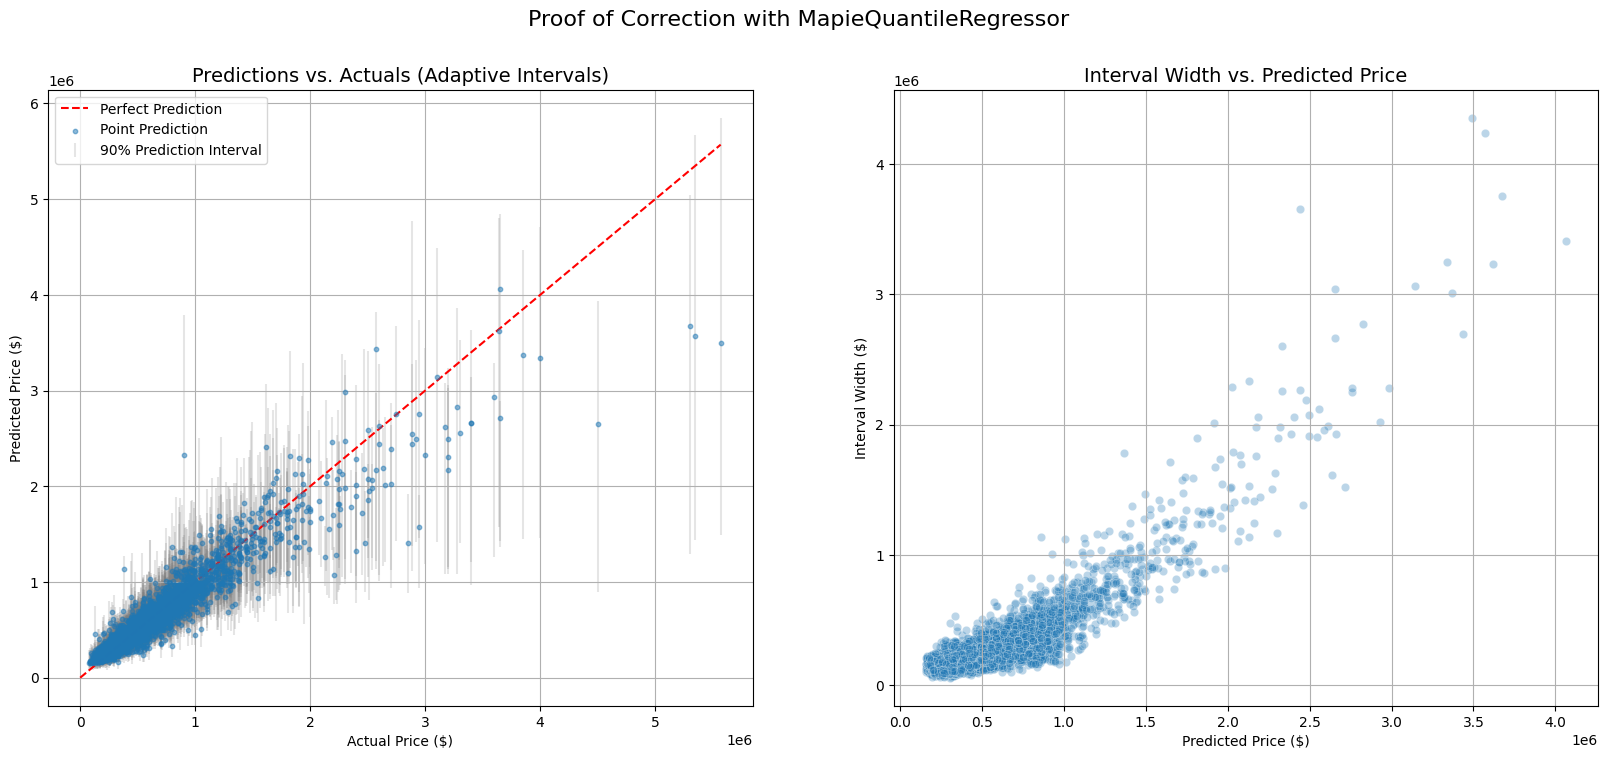

In [ ]:
# --- Get predictions and convert to dollars

y_pred_log_qr, y_pis_log_qr = mapie_qr.predict(X_test_selected)
y_pred_dollars_qr = np.exp(y_pred_log_qr)
y_pis_dollars_qr = np.exp(y_pis_log_qr)
lower_bound_qr = y_pis_dollars_qr[:, 0, 0]
upper_bound_qr = y_pis_dollars_qr[:, 1, 0]

# Create a results dataframe for analysis
results_df_qr = pd.DataFrame({
    'y_true': y_test_dollars,
    'y_pred': y_pred_dollars_qr,
    'lower': lower_bound_qr,
    'upper': upper_bound_qr
})
results_df_qr['interval_width'] = results_df_qr['upper'] - results_df_qr['lower']
results_df_qr['covered'] = (results_df_qr['y_true'] >= results_df_qr['lower']) & (results_df_qr['y_true'] <= results_df_qr['upper'])

# Plot the corrected diagnostic charts
fig, axes = plt.subplots(1, 2, figsize=(20, 8))
fig.suptitle("Proof of Correction with MapieQuantileRegressor", fontsize=16)

# Plot 1: Adaptive Intervals
ax1 = axes[0]
ax1.plot([0, y_test_dollars.max()], [0, y_test_dollars.max()], "r--", label="Perfect Prediction")
ax1.scatter(results_df_qr['y_true'], results_df_qr['y_pred'], s=10, alpha=0.5, label="Point Prediction", zorder=5)

# np.abs() to ensure yerr is always positive. This correctly calculates the distance from the point to the bounds.
y_err_dist = (
    np.abs(results_df_qr['y_pred'] - results_df_qr['lower']),
    np.abs(results_df_qr['upper'] - results_df_qr['y_pred'])
)

# Plot intervals
ax1.errorbar(
    results_df_qr['y_true'],
    results_df_qr['y_pred'],
    yerr=y_err_dist,
    fmt="none",
    alpha=0.2,
    ecolor="grey",
    capsize=0,
    label="90% Prediction Interval",
    zorder=1
)
ax1.set_title("Predictions vs. Actuals (Adaptive Intervals)", fontsize=14)
ax1.set_xlabel("Actual Price ($)"); ax1.set_ylabel("Predicted Price ($)"); ax1.grid(True); ax1.legend()

# Plot 2: The "Money Shot" - Interval Width vs. Predicted Price
ax2 = axes[1]
sns.scatterplot(data=results_df_qr, x='y_pred', y='interval_width', alpha=0.3, ax=ax2)
ax2.set_title("Interval Width vs. Predicted Price", fontsize=14)
ax2.set_xlabel("Predicted Price ($)"); ax2.set_ylabel("Interval Width ($)"); ax2.grid(True)
plt.show()

This is the results from the new techinique to solve the confidential problem.

*   Predictions vs. Actuals (Adaptive Intervals) - Left Plot: This plot immediately looks different just by looking at the grey error bars. For the dense cluster of points under $1M, the intervals are, mostly, very short and tight.
As we move to the right toward more expensive houses, the vertical error bars get progressively longer.
This shows the model is now generating adaptive intervals. It is correctly assigning a small amount of uncertainty to low-priced homes and a large amount of uncertainty to high-priced homes.

*   Interval Width vs. Predicted Price - Right Plot:
There is a strong and positive correlation.
As the Predicted Price on the x-axis increases, the Interval Width on the y-axis also increases.
This plot proves the needs to use "adaptive-width" interval model instead of a "constant-width" ones.




In [ ]:
# --- Quantitative Analysis of Corrected Intervals

price_bins_labels = [
    "1. Lowest Price (Bottom 20%)", "2. Low-Mid Price (20-40%)",
    "3. Mid Price (40-60%)", "4. High-Mid Price (60-80%)", "5. Highest Price (Top 20%)"
]
results_df_qr['price_bin'] = pd.qcut(results_df_qr['y_true'], q=5, labels=price_bins_labels)

binned_analysis = results_df_qr.groupby('price_bin', observed=True).agg(
    Coverage=('covered', 'mean'),
    Avg_Interval_Width=('interval_width', 'mean'),
    Avg_True_Price=('y_true', 'mean'),
    Count=('y_true', 'count')
).reset_index()

# Format for final presentation
binned_analysis['Coverage'] = binned_analysis['Coverage'].map('{:.1%}'.format)
binned_analysis['Avg_Interval_Width'] = binned_analysis['Avg_Interval_Width'].map('${:,.0f}'.format)
binned_analysis['Avg_True_Price'] = binned_analysis['Avg_True_Price'].map('${:,.0f}'.format)
print(binned_analysis.to_string(index=False))

                   price_bin Coverage Avg_Interval_Width Avg_True_Price  Count
1. Lowest Price (Bottom 20%)    85.1%           $142,490       $239,228   1305
   2. Low-Mid Price (20-40%)    92.2%           $165,155       $346,416   1289
       3. Mid Price (40-60%)    93.4%           $212,003       $455,102   1296
  4. High-Mid Price (60-80%)    91.4%           $280,552       $605,485   1297
  5. Highest Price (Top 20%)    85.0%           $575,206     $1,083,360   1297


From this last table I can quantify the uncertainty of the model. As said at the beginning of this analysis, the model used to do the predictions is LGBMRegressor (this is done to its "ability" of objective="quantile").

The interval are adaptive: for the cheapest 20% houses (with an average price of \$239k), the width is \$142k, instead for the top 20% most expensive house (average price of \$1.1M), the width of the prediction interval is \$575k.
The model correctly identifies that there is far more risk and uncertainty when predicting the price of a unique, high-end property than a standard, entry-level home.

An "interesting" finding is by the "coverage" column. The coverage target was 90%.

*   Overconfidence: For the cheapest (85.1%) and most expensive (85.0%) houses, the actual coverage is below the 90% target. This means the model is slightly overconfident in these brackets. Its prediction intervals, while wide for expensive homes, are still a little too narrow to capture the true price 90% of the time. These properties likely have unique features that the model doesn't fully grasp.

*   Over-cautiousness: For the mid-range houses (92.2% and 93.4%), the coverage is above the 90% target. This means the model is slightly underconfident here. Its intervals are a bit wider than they need to be. These "standard" homes are likely easier to model, so the predictions are more stable, and fewer true prices fall outside the interval than the model expects.

In conclusion:

*   For mid-range homes (\$350k - \$600k) the model is highly reliable. The 90% confidence intervals are tight, and they successfully capture the true price over 92% of the time, exceeding our target.

*   For an entry-level home (\$240k), the 90% interval is about \$142k wide, but there is a ~15% chance the true price will fall outside this range.

*   For a luxury home (\$1.1M), the uncertainty is much greater. The 90% interval is over \$575k wide, and we should still expect a ~15% chance of the true price falling outside this wide band.


# SHAP for Model Interpretation
After evaluating our models, the next step is to understand *why* they make the predictions they do. For this, I'll use SHAP (SHapley Additive exPlanations). It tells us how much each feature contributed to pushing a prediction away from the baseline (the average prediction).
I will apply SHAP to our best-performing tree-based model (XGBoost).
My analysis will cover:

1.  Global Feature Importance: Which features have the biggest impact on predictions overall?
2.  Feature Dependence and Interaction: How does the value of a key feature (like "sqft_living") affect its impact, and how does it interact with other features (like "grade")?
3.  Individual Prediction Breakdown: For a specific house (e.g., the most expensive one), what were the exact factors that drove its price prediction up or down?

In [ ]:
# --- Setup for SHAP

best_xgb_pipeline = model_results["XGBoost_OPTUNA"]['best_estimator']

# Extract the fitted XGBoost model from the pipeline
xgb_model = best_xgb_pipeline.named_steps["model"]

In [ ]:
# The data used for SHAP should be the same as what the model was trained on: X_train_selected
# For better visualization, we'll create cleaner feature names for our plots.
clean_feature_names = {
    col: col.split("__")[-1].replace("_", " ").title()
    for col in X_train_selected.columns
}

X_train_selected_renamed = X_train_selected.rename(columns=clean_feature_names)
X_test_selected_renamed = X_test_selected.rename(columns=clean_feature_names)

In [ ]:
# --- Calculate SHAP Values

# Create the explainer object using the trained XGBoost model
explainer = shap.TreeExplainer(xgb_model)

print("Calculating SHAP values for the test set.")

# Calculate SHAP values for the test data (the result is a numpy array)
shap_values = explainer.shap_values(X_test_selected_renamed)

print("SHAP values calculated.")

Calculating SHAP values for the test set.
SHAP values calculated.


In [ ]:
# --- TreeExplainer save

joblib.dump(explainer, 'shap_explainer.joblib')

['shap_explainer.joblib']

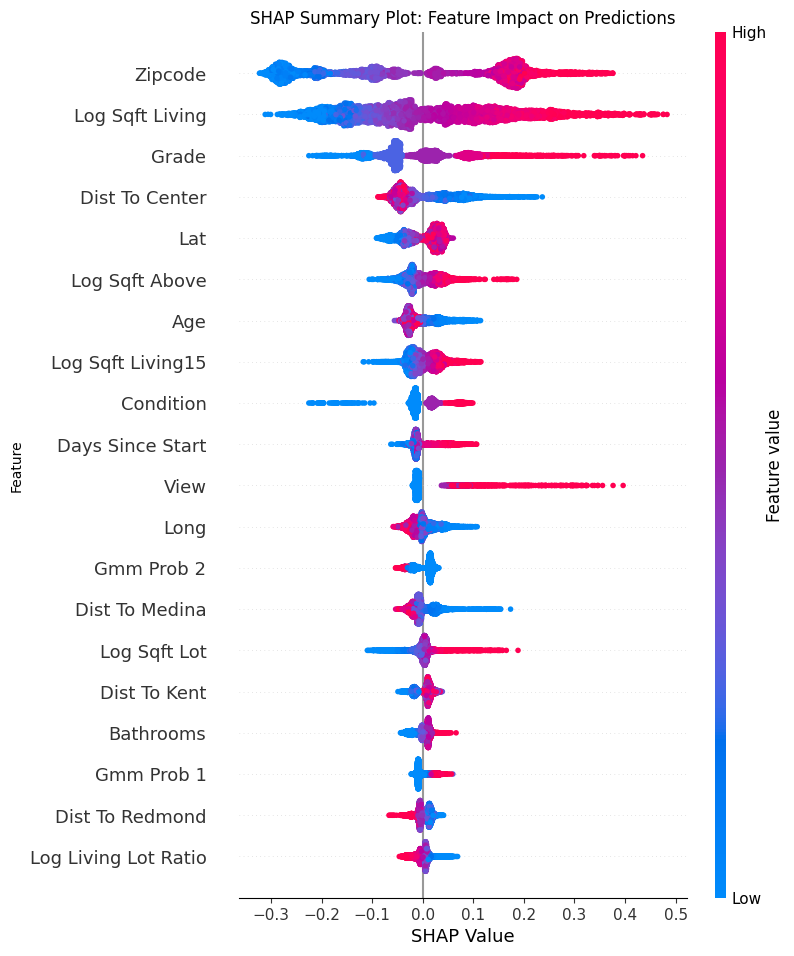

In [ ]:
# --- Global Feature Importance

shap.summary_plot(shap_values, X_test_selected_renamed, plot_type="dot", show=False)
plt.title("SHAP Summary Plot: Feature Impact on Predictions")
plt.xlabel("SHAP Value")
plt.ylabel("Feature")
plt.show()

Global Feature Importance

The "beeswarm" plot summarizes the impact of each feature across all the houses in the test set. Each dot represents a single house's prediction.

*   Feature Importance: Features are ranked by importance on the y-axis.
*   Impact on Prediction: The x-axis shows the SHAP value. A positive value means the feature pushed the price prediction higher, while a negative value pushed it lower.
*   Original Feature Value: The color indicates the feature's value, from low (blue) to high (red).

As we can see, Log_Sqft_Living is by far the most important feature. As expected, high values (red dots) have a large positive SHAP value, strongly increasing the predicted price. The same can be said for grade and view.
Latitudeand and Longitude show a clear geographical pattern. High latitude (more northern, red dots) increases the price, while high longitude (more eastern) has a mixed but generally positive impact. This captures the value of specific neighborhoods. The complement of lat and long is dist to center: as we distance from the center increase (low dots) the price decrese.

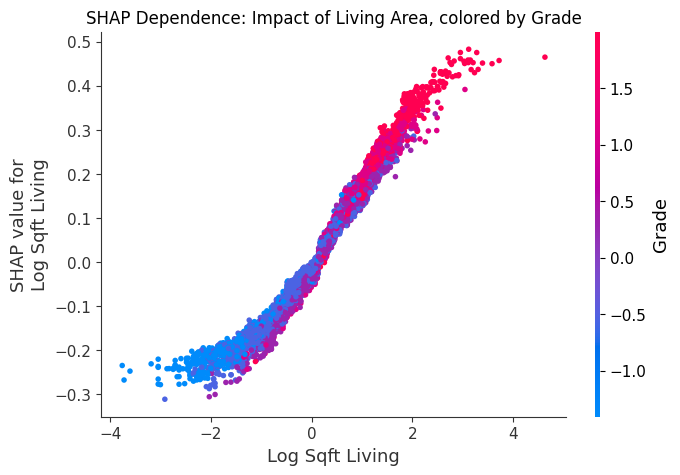

In [ ]:
# --- SHAP Dependence Plot
# This shows how a single feature's value affects its SHAP value (its impact on the prediction).

shap.dependence_plot(
    "Log Sqft Living",
    shap_values,
    X_test_selected_renamed,
    interaction_index="Grade",
    show=False
)

plt.title("SHAP Dependence: Impact of Living Area, colored by Grade")
plt.show()


The plot shows a clear and strong positive trend. As Log Sqft Living (x-axis) increases, its SHAP value (y-axis) also increases. This confirms the primary relationship: the larger the house, the more its size contributes to a higher price prediction.
The vertical spread of colors is the most telling part of this plot. For any given value of Log Sqft Living, the dots are colored from blue (low Grade) at the bottom to red (high Grade) at the top.


Displaying SHAP Force Plot for a random property (Index: 10275)


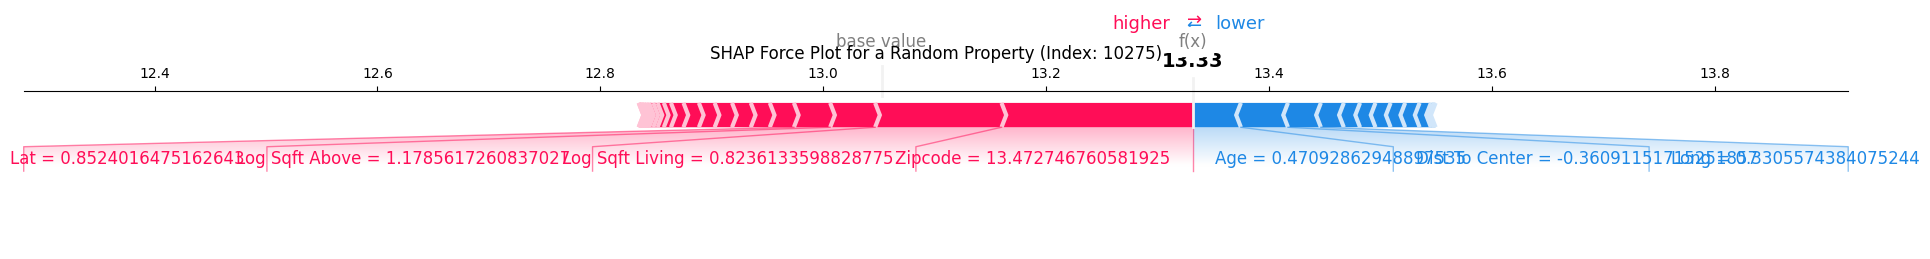

In [ ]:
# --- Individual Prediction (force plot breaks down how each feature contributed to one specific prediction)

# Pick a random index label from the test set
random_idx = random.choice(X_test_selected_renamed.index.tolist())

# Find its integer position
test_set_position = X_test_selected_renamed.index.get_loc(random_idx)

print(f"\nDisplaying SHAP Force Plot for a random property (Index: {random_idx})")

# Generate the force plot
shap.force_plot(
    explainer.expected_value,
    shap_values[test_set_position, :],
    X_test_selected_renamed.iloc[test_set_position, :],
    matplotlib=True,
    show=False
)
plt.title(f"SHAP Force Plot for a Random Property (Index: {random_idx})")
plt.tight_layout()
plt.show()